=== Marine Bioacoustic and Geophonic Sound Classification ===

Loading biophonic dataset (max 100 files per category)...
Loading cached data from ./audio_cache/7b081655_max300_features.npy

Loading geophonic dataset (max 100 files per category)...
Loading cached data from ./audio_cache/1ad7540f_max300_features.npy

Preprocessing data...
Loading preprocessed data from cache

Splitting data...

Training model...
Epoch 1/150
47/47 [==============================] - 1s 11ms/step - loss: 1.0421 - accuracy: 0.7855 - precision: 0.8869 - recall: 0.7518 - auc: 0.9547 - val_loss: 0.6502 - val_accuracy: 0.8831 - val_precision: 0.9473 - val_recall: 0.7245 - val_auc: 0.9855 - lr: 0.0010
Epoch 2/150
47/47 [==============================] - 0s 4ms/step - loss: 0.2824 - accuracy: 0.9250 - precision: 0.9531 - recall: 0.9092 - auc: 0.9929 - val_loss: 0.3310 - val_accuracy: 0.9086 - val_precision: 0.9535 - val_recall: 0.8817 - val_auc: 0.9936 - lr: 0.0010
Epoch 3/150
47/47 [==============================

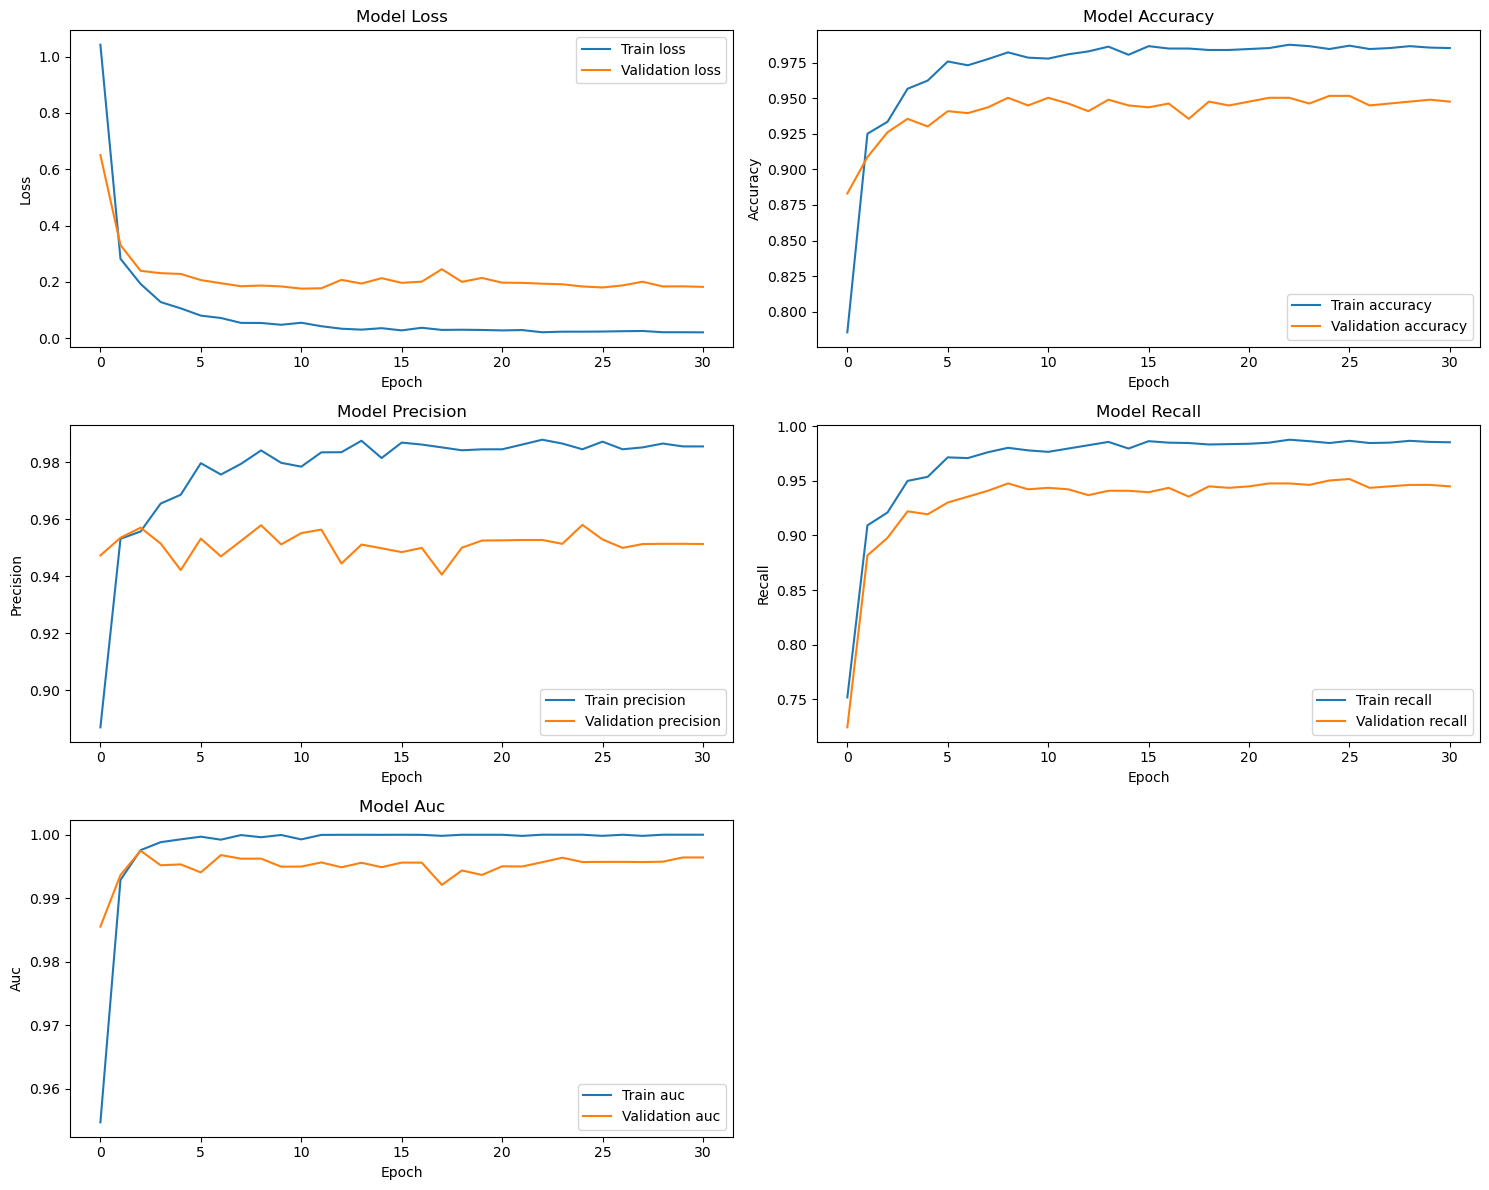

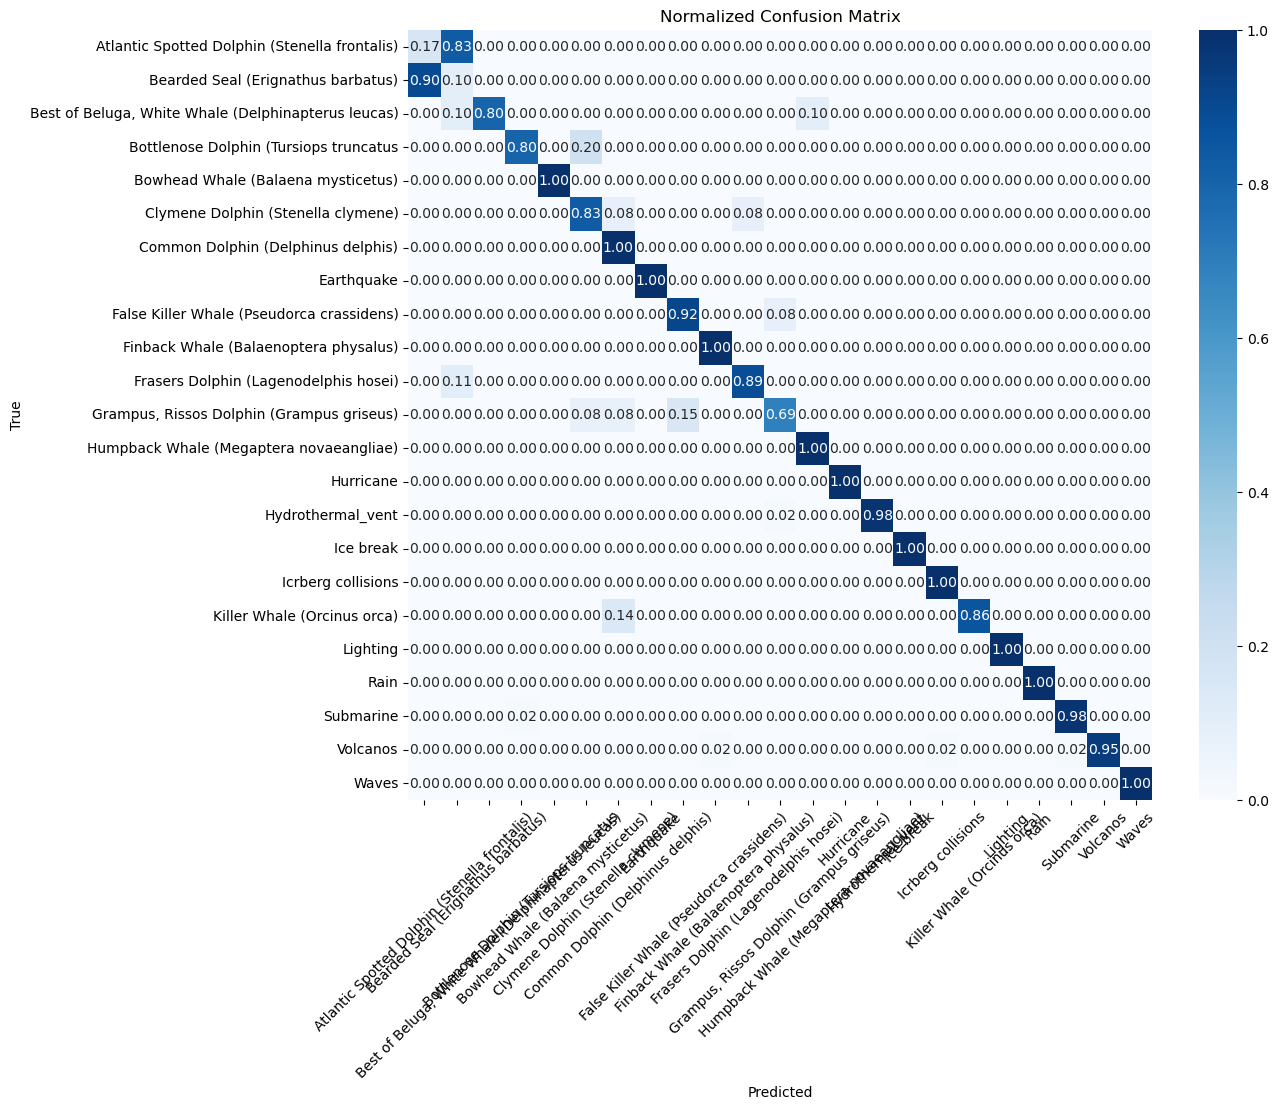


=== Spectrum Management Demonstration ===

Analyzing: 61079006.wav
Analysis error: Graph execution error:

Detected at node 'model_3/dense_23/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/opt/h

In [4]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report)
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import pandas as pd
import time
import soundfile as sf
import joblib
import hashlib
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Enhanced Audio Data Loader with Caching (from original code)
# --------------------------

class AudioDataLoader:
    """Handles loading and preprocessing with limit on files per category"""
    
    def __init__(self, target_sr=22050, max_duration=5, n_mfcc=40, cache_dir='./cache', max_files_per_category=100):
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.n_mfcc = n_mfcc
        self.le = LabelEncoder()
        self.supported_formats = ('.wav', '.mp3', '.WAV', '.MP3')
        self.cache_dir = cache_dir
        self.max_files = max_files_per_category
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def _get_cache_path(self, root_path, suffix):
        """Generate cache file path with limit parameter in name"""
        root_hash = hashlib.md5(root_path.encode()).hexdigest()[:8]
        return os.path.join(self.cache_dir, f"{root_hash}_max{self.max_files}_{suffix}")
        
    def is_audio_file(self, filename):
        return filename.lower().endswith(self.supported_formats)
    
    def load_audio_file(self, file_path):
        try:
            # Try librosa first
            try:
                duration = librosa.get_duration(filename=file_path)
                duration = min(duration, self.max_duration)
                audio, sr = librosa.load(
                    file_path,
                    sr=self.target_sr,
                    duration=duration,
                    mono=True,
                    res_type='kaiser_fast'
                )
                return audio, True
            except:
                # Fallback to soundfile
                try:
                    with sf.SoundFile(file_path) as f:
                        duration = min(len(f) / f.samplerate, self.max_duration)
                        target_frames = int(duration * self.target_sr)
                        audio = f.read(frames=target_frames, dtype='float32', always_2d=True)
                        if audio.ndim > 1 and audio.shape[1] > 1:
                            audio = np.mean(audio, axis=1)
                        else:
                            audio = audio.flatten()
                        if f.samplerate != self.target_sr:
                            audio = librosa.resample(audio, orig_sr=f.samplerate, target_sr=self.target_sr)
                        return audio, True
                except Exception as e:
                    print(f"Error loading {file_path}: {str(e)}")
                    return None, False
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            return None, False
    
    def load_dataset(self, root_path, use_cache=True):
        features_cache = self._get_cache_path(root_path, "features.npy")
        labels_cache = self._get_cache_path(root_path, "labels.npy")
        paths_cache = self._get_cache_path(root_path, "paths.npy")
        
        if use_cache and all(os.path.exists(f) for f in [features_cache, labels_cache, paths_cache]):
            try:
                print(f"Loading cached data from {features_cache}")
                return np.load(features_cache), np.load(labels_cache), np.load(paths_cache, allow_pickle=True)
            except Exception as e:
                print(f"Error loading cache: {str(e)}. Reprocessing data.")
        
        features, labels, file_paths = [], [], []
        error_count = 0
        total_files = 0
        
        # Count total files first (for progress tracking)
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if os.path.isdir(label_path):
                total_files += min(len([f for f in os.listdir(label_path) if self.is_audio_file(f)]), 
                                self.max_files)
        
        processed_files = 0
        start_time = time.time()
        
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if not os.path.isdir(label_path):
                continue
                
            print(f"\nProcessing category: {label}...")
            files_processed = 0
            
            for file in os.listdir(label_path):
                if not self.is_audio_file(file):
                    continue
                    
                # Enforce file limit per category
                if files_processed >= self.max_files:
                    break
                    
                file_path = os.path.join(label_path, file)
                processed_files += 1
                files_processed += 1
                
                if processed_files % 10 == 0:
                    elapsed = time.time() - start_time
                    remaining = (elapsed/processed_files) * (total_files-processed_files)
                    print(f"  Progress: {processed_files}/{total_files} ({remaining:.1f}s remaining)")
                
                audio, success = self.load_audio_file(file_path)
                if not success:
                    error_count += 1
                    continue
                    
                try:
                    feature_vector = self.extract_features(audio)
                    if feature_vector is not None:  # Only add if feature extraction succeeded
                        features.append(feature_vector)
                        labels.append(label)
                        file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    error_count += 1
        
        # Verify all features have same length before converting to array
        if features:
            feature_length = len(features[0])
            features = [f for f in features if len(f) == feature_length]
            print(f"Final feature vector length: {feature_length}")
            print(f"Number of valid samples: {len(features)}")
            
            features = np.array(features)
            labels = np.array(labels)
            file_paths = np.array(file_paths)
        else:
            features = np.array([])
            labels = np.array([])
            file_paths = np.array([])
        
        if use_cache and len(features) > 0:
            try:
                np.save(features_cache, features)
                np.save(labels_cache, labels)
                np.save(paths_cache, file_paths)
                print(f"Saved processed data to cache: {features_cache}")
            except Exception as e:
                print(f"Error saving cache: {str(e)}")
        
        print(f"\nCompleted loading. Total errors: {error_count}/{total_files}")
        return features, labels, file_paths

    def extract_features(self, audio):
        """Extract comprehensive audio features with consistent length"""
        try:
            features = []
            
            # MFCCs with delta features (always produces n_mfcc coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=self.target_sr, n_mfcc=self.n_mfcc)
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2)
            
            # Always take first n_mfcc coefficients for each
            features.extend(np.mean(mfccs, axis=1)[:self.n_mfcc])
            features.extend(np.std(mfccs, axis=1)[:self.n_mfcc])
            features.extend(np.mean(delta_mfccs, axis=1)[:self.n_mfcc])
            features.extend(np.mean(delta2_mfccs, axis=1)[:self.n_mfcc])
            
            # Spectral features (fixed number)
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=self.target_sr)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=self.target_sr)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=self.target_sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(spectral_centroid), np.std(spectral_centroid),
                np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
                *np.mean(spectral_contrast, axis=1)[:7],  # First 7 contrast bands
                np.mean(spectral_rolloff), np.std(spectral_rolloff)
            ])
            
            # Temporal features (fixed number)
            zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)
            rmse = librosa.feature.rms(y=audio)
            tempogram = librosa.feature.tempogram(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
                np.mean(rmse), np.std(rmse),
                np.mean(tempogram), np.std(tempogram)
            ])
            
            # Chroma features (fixed 12 bins)
            chroma = librosa.feature.chroma_stft(y=audio, sr=self.target_sr)
            features.extend(np.mean(chroma, axis=1)[:12]) # First 12 chroma bins
            features.extend(np.std(chroma, axis=1)[:12])
            
            return features
            
        except librosa.util.exceptions.ParameterError as e:
            print(f"Librosa parameter error in feature extraction: {str(e)}")
            return None
        except ValueError as e:
            print(f"Value error in feature extraction: {str(e)}")
            return None
        except Exception as e:
            print(f"Unexpected error in feature extraction: {str(e)}")
            return None
    
    def preprocess_data(self, X, y, use_cache=True):
        """Encode labels and scale features with caching"""
        cache_prefix = self._get_cache_path("preprocessed", "")
        
        # Try to load from cache
        if use_cache and os.path.exists(cache_prefix + "X_scaled.npy"):
            try:
                print("Loading preprocessed data from cache")
                X_scaled = np.load(cache_prefix + "X_scaled.npy")
                y_categorical = np.load(cache_prefix + "y_categorical.npy")
                self.le = joblib.load(cache_prefix + "label_encoder.joblib")
                scaler = joblib.load(cache_prefix + "scaler.joblib")
                return X_scaled, y_categorical, self.le.classes_
            except Exception as e:
                print(f"Error loading preprocessed cache: {str(e)}. Reprocessing data.")
        
        if len(X) == 0 or len(y) == 0:
            raise ValueError("No valid data to preprocess")
            
        # Encode labels
        y_encoded = self.le.fit_transform(y)
        y_categorical = to_categorical(y_encoded)
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Save to cache
        if use_cache:
            try:
                np.save(cache_prefix + "X_scaled.npy", X_scaled)
                np.save(cache_prefix + "y_categorical.npy", y_categorical)
                joblib.dump(self.le, cache_prefix + "label_encoder.joblib")
                joblib.dump(scaler, cache_prefix + "scaler.joblib")
                print("Saved preprocessed data to cache")
            except Exception as e:
                print(f"Error saving preprocessed cache: {str(e)}")
        
        return X_scaled, y_categorical, self.le.classes_

# --------------------------
# 2. Fixed Model Architecture (modified to fix shape error)
# --------------------------

class BioGeoClassifier:
    """Classifier with fixed architecture to handle shape mismatch"""
    
    def __init__(self, input_shape, num_classes):
        self.model = self.build_model(input_shape, num_classes)
        
    def build_model(self, input_shape, num_classes):
        """Construct neural network with proper shape handling"""
        inputs = layers.Input(shape=input_shape)
        
        # Initial dense layer
        x = layers.Dense(256, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # First residual block (matching dimensions)
        residual = layers.Dense(256)(x)  # Project residual to match dimensions
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Attention mechanism
        attention = layers.Dense(128, activation='tanh')(x)
        attention = layers.Dense(1, activation='softmax')(attention)
        attention = layers.Flatten()(attention)
        attention = layers.RepeatVector(256)(attention)
        attention = layers.Permute([2, 1])(attention)
        x = layers.Multiply()([x, attention])
        
        # Second residual block
        residual = x  # No projection needed since dimensions match
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Output - Fixed shape issue by adding Flatten() before final Dense
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.legacy.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Training with callbacks"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history

# --------------------------
# 3. Enhanced Evaluation & Visualization (from original code)
# --------------------------

class ResultVisualizer:
    """Enhanced visualization with more metrics"""
    
    @staticmethod
    def plot_training_history(history):
        """Plot training and validation metrics"""
        metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
        plt.figure(figsize=(15, 12))
        
        for i, metric in enumerate(metrics):
            plt.subplot(3, 2, i+1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(f'Model {metric.capitalize()}')
            plt.ylabel(metric.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names):
        """Enhanced confusion matrix visualization"""
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.show()
    
    @staticmethod
    def plot_spectral_features(audio_path, sr=22050):
        """Enhanced spectral feature visualization"""
        y, sr = librosa.load(audio_path, sr=sr)
        
        plt.figure(figsize=(15, 10))
        
        # Waveform
        plt.subplot(3, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title('Audio Waveform')
        
        # Spectrogram
        plt.subplot(3, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Log-frequency power spectrogram')
        
        # MFCCs
        plt.subplot(3, 1, 3)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        
        plt.tight_layout()
        plt.show()

# --------------------------
# 4. Enhanced Spectrum Management System (from original code)
# --------------------------

class SpectrumManager:
    """Enhanced spectrum allocation with priority management"""
    
    def __init__(self, classifier, label_encoder):
        self.classifier = classifier
        self.label_encoder = label_encoder
        self.band_allocation = {
            'infrasonic': (1, 20),    # Earthquakes
            'low': (20, 500),        # Hurricanes, waves
            'mid': (500, 20000),      # Marine mammals
            'high': (20000, 40000)    # Backup
        }
        self.current_allocations = []
        self.priority_map = {
            'dolphin': 3,    # Highest priority
            'whale': 3,
            'minke_whale': 3,
            'hurricane': 2,
            'earthquake': 1,  # Lowest priority
            'wave': 1
        }
        
    def analyze_audio(self, audio):
        """Enhanced audio analysis with error handling"""
        try:
            # Extract features
            loader = AudioDataLoader()
            features = loader.extract_features(audio)
            if features is None:
                return None, None
                
            features = np.array(features).reshape(1, -1)
            
            # Classify
            pred = self.classifier.predict(features)
            class_idx = np.argmax(pred)
            sound_class = self.label_encoder[class_idx]
            
            # Frequency analysis
            freqs = np.fft.rfftfreq(len(audio), d=1/22050)
            fft = np.abs(np.fft.rfft(audio))
            
            band_energy = {}
            for band, (low, high) in self.band_allocation.items():
                mask = (freqs >= low) & (freqs <= high)
                band_energy[band] = np.sum(fft[mask])
            
            return sound_class, band_energy
        except Exception as e:
            print(f"Analysis error: {str(e)}")
            return None, None
    
    def allocate_band(self, sound_class, band_energy):
        """Enhanced allocation with priority system"""
        if sound_class not in self.priority_map:
            sound_class = 'other'
            
        allocation = {
            'primary': None,
            'secondary': None,
            'priority': self.priority_map.get(sound_class, 0)
        }
        
        # Priority-based allocation
        if sound_class in ['dolphin', 'whale', 'minke_whale']:
            allocation['primary'] = 'mid'
            allocation['secondary'] = 'high'
        elif sound_class == 'earthquake':
            allocation['primary'] = 'infrasonic'
        elif sound_class == 'hurricane':
            # Dynamic allocation based on current usage
            if band_energy['mid'] > 0.5 * band_energy['low']:
                allocation['primary'] = 'low'
            else:
                allocation['primary'] = 'mid'
        else:
            # Default allocation for unknown classes
            allocation['primary'] = 'low'
            
        return allocation
    
    def visualize_allocation(self):
        """Enhanced visualization with priority information"""
        if not self.current_allocations:
            print("No allocations to visualize")
            return
            
        plt.figure(figsize=(12, 8))
        
        # Create a color map based on priority
        colors = {1: 'lightblue', 2: 'orange', 3: 'red'}
        
        for alloc in self.current_allocations:
            band_range = self.band_allocation[alloc['band']]
            plt.barh(
                alloc['class'], 
                width=band_range[1]-band_range[0],
                left=band_range[0],
                alpha=0.6,
                color=colors.get(alloc['priority'], 'gray'),
                label=f"{alloc['class']} (Priority {alloc['priority']})"
            )
        
        plt.title('Current Spectrum Allocation with Priority')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Sound Class')
        plt.xscale('log')
        plt.grid(True, which="both", ls="--")
        
        # Create custom legend
        handles = [
            plt.Rectangle((0,0),1,1, color='red', alpha=0.6, label='High Priority (Marine Mammals)'),
            plt.Rectangle((0,0),1,1, color='orange', alpha=0.6, label='Medium Priority (Weather)'),
            plt.Rectangle((0,0),1,1, color='lightblue', alpha=0.6, label='Low Priority (Geophonic)')
        ]
        plt.legend(handles=handles)
        
        plt.show()

def main():
    print("=== Marine Bioacoustic and Geophonic Sound Classification ===")
    
    # Initialize with max 100 files per category
    loader = AudioDataLoader(
        target_sr=44100,
        max_duration=4,
        n_mfcc=60,
        cache_dir='./audio_cache',
        max_files_per_category=300  # Added limit here
    )
    
    # Load datasets (will automatically respect the 100 file limit)
    print("\nLoading biophonic dataset (max 100 files per category)...")
    bio_X, bio_y, bio_paths = loader.load_dataset(
        "/Users/fatbatman/Develop/Liquid Neural Network/dataset",
        use_cache=True
    )
    
    print("\nLoading geophonic dataset (max 100 files per category)...")
    geo_X, geo_y, geo_paths = loader.load_dataset(
        "/Users/fatbatman/Downloads/Dataset",
        use_cache=True
    )
    
    
    if len(bio_X) == 0 or len(geo_X) == 0:
        print("Error: No valid data loaded. Check your dataset paths and file formats.")
        return
    
    # 3. Combine and preprocess data with caching
    print("\nPreprocessing data...")
    X = np.concatenate((bio_X, geo_X))
    y = np.concatenate((bio_y, geo_y))
    
    try:
        X_scaled, y_categorical, class_names = loader.preprocess_data(X, y, use_cache=True)
    except ValueError as e:
        print(f"Preprocessing error: {str(e)}")
        return
    
    # 4. Split data with stratification
    print("\nSplitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_categorical, 
        test_size=0.2, 
        random_state=42,
        stratify=y_categorical
    )
    
    # 5. Train model with fixed architecture
    print("\nTraining model...")
    classifier = BioGeoClassifier(
        input_shape=(X_train.shape[1],), 
        num_classes=len(class_names)
    )
    
    history = classifier.train(
        X_train, y_train,
        X_test, y_test,
        epochs=150,
        batch_size=64
    )
    
    # 6. Comprehensive evaluation
    print("\nEvaluating model performance...")
    y_pred = classifier.model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    print(f"\n=== Final Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    
    # 7. Enhanced visualizations
    visualizer = ResultVisualizer()
    visualizer.plot_training_history(history)
    visualizer.plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)
    
    # 8. Spectrum management demonstration
    print("\n=== Spectrum Management Demonstration ===")
    spectrum_manager = SpectrumManager(classifier.model, class_names)
    
    # Analyze sample files
    sample_paths = [
        np.random.choice(bio_paths),  # Random biophonic sample
        np.random.choice(geo_paths)   # Random geophonic sample
    ]
    
    for path in sample_paths:
        print(f"\nAnalyzing: {os.path.basename(path)}")
        
        # Load and analyze
        audio, _ = librosa.load(path, sr=44100, duration=4)
        sound_class, band_energy = spectrum_manager.analyze_audio(audio)
        
        if sound_class is None:
            print("Analysis failed for this sample")
            continue
            
        allocation = spectrum_manager.allocate_band(sound_class, band_energy)
        
        print(f"Classified as: {sound_class}")
        print("Band Energy Distribution:")
        for band, energy in band_energy.items():
            print(f"  {band}: {energy:.2f}")
        print("Allocation:", allocation)
        
        # Add to current allocations
        spectrum_manager.current_allocations.append({
            'class': sound_class,
            'band': allocation['primary'],
            'priority': allocation['priority'],
            'energy': band_energy[allocation['primary']]
        })
        
        # Visualize sample features
        visualizer.plot_spectral_features(path)
    
    # Show final spectrum allocation
    spectrum_manager.visualize_allocation()

if __name__ == "__main__":
    import tensorflow as tf
    main()

=== Marine Bioacoustic Classification System ===

Loading biophonic dataset...
Loading cached data from ./audio_cache/7b081655_max300_features.npy

Loading geophonic dataset...
Loading cached data from ./audio_cache/1ad7540f_max300_features.npy

Preprocessing data...
Loading preprocessed data from cache

Splitting data...

Available models:
1. CNN Model
2. Vision Transformer (ViT) Model
3. Hybrid Model (CNN + Transformer)

Training CNN model...
Epoch 1/150
47/47 [==============================] - 5s 91ms/step - loss: 1.3745 - accuracy: 0.6890 - precision: 0.9714 - recall: 0.2972 - auc: 0.9615 - val_loss: 2.7857 - val_accuracy: 0.1452 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7668 - lr: 0.0010
Epoch 2/150
47/47 [==============================] - 5s 101ms/step - loss: 0.6149 - accuracy: 0.8631 - precision: 0.9864 - recall: 0.7542 - auc: 0.9922 - val_loss: 3.3632 - val_accuracy: 0.0806 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7391 - lr: 0.0

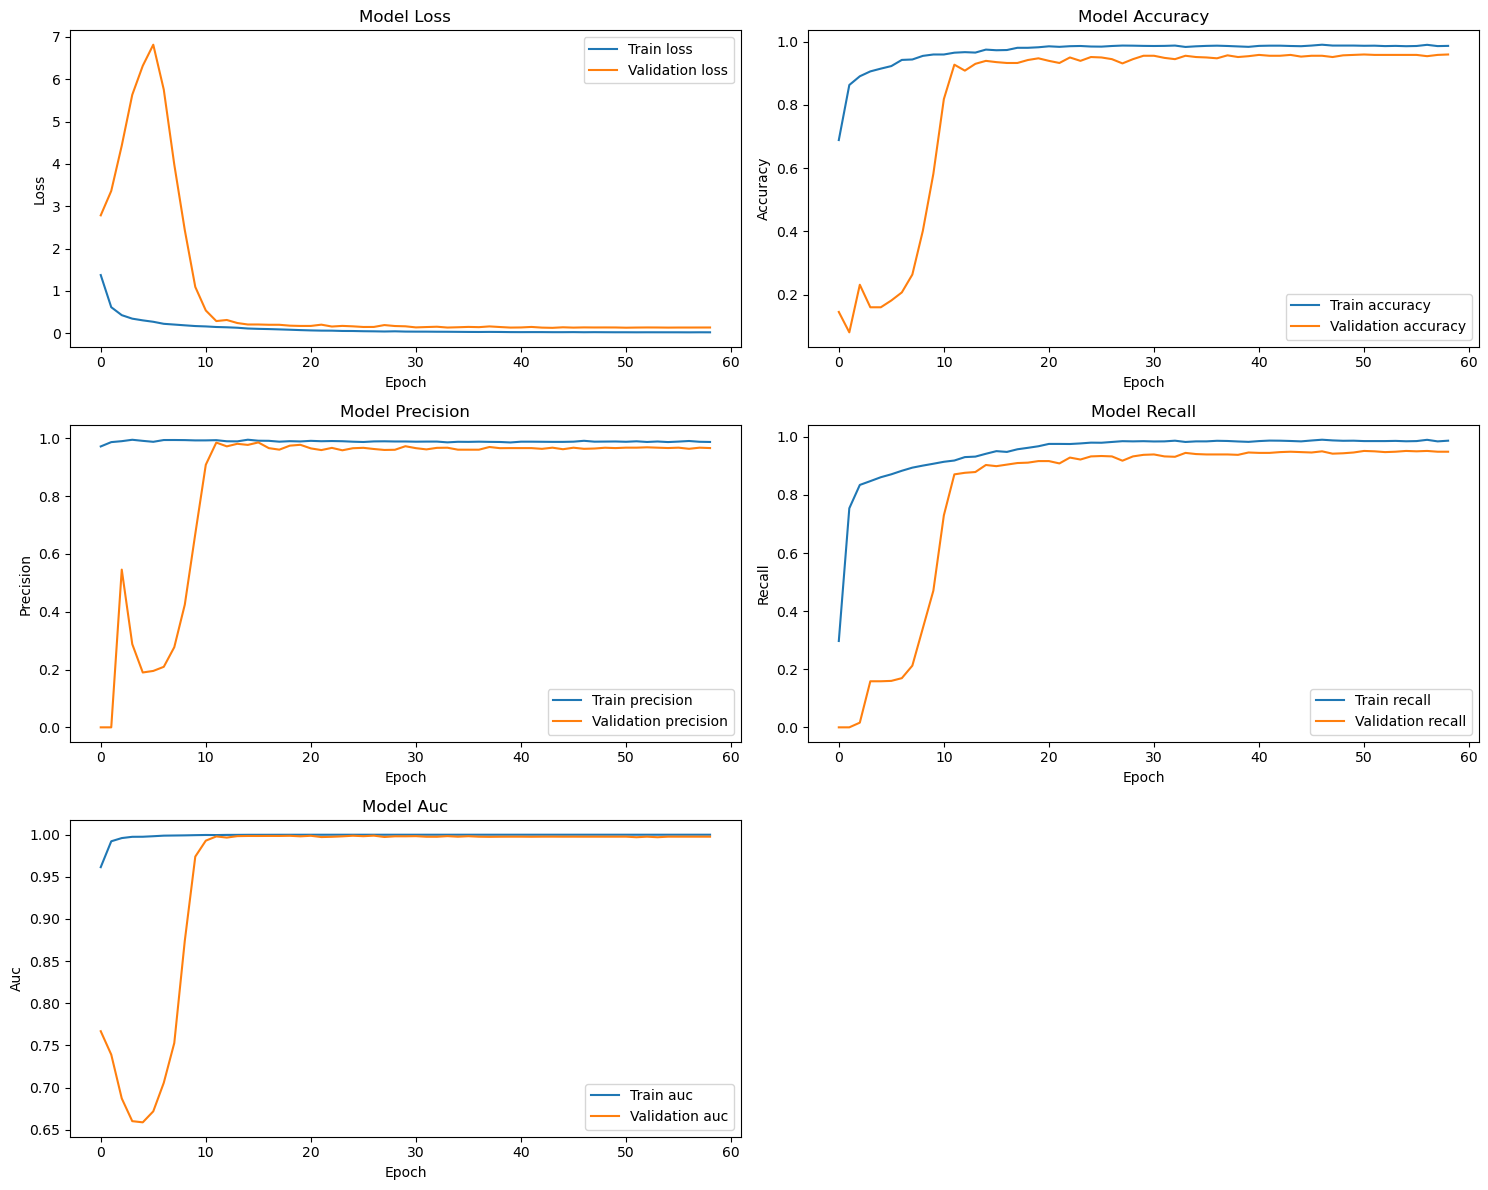

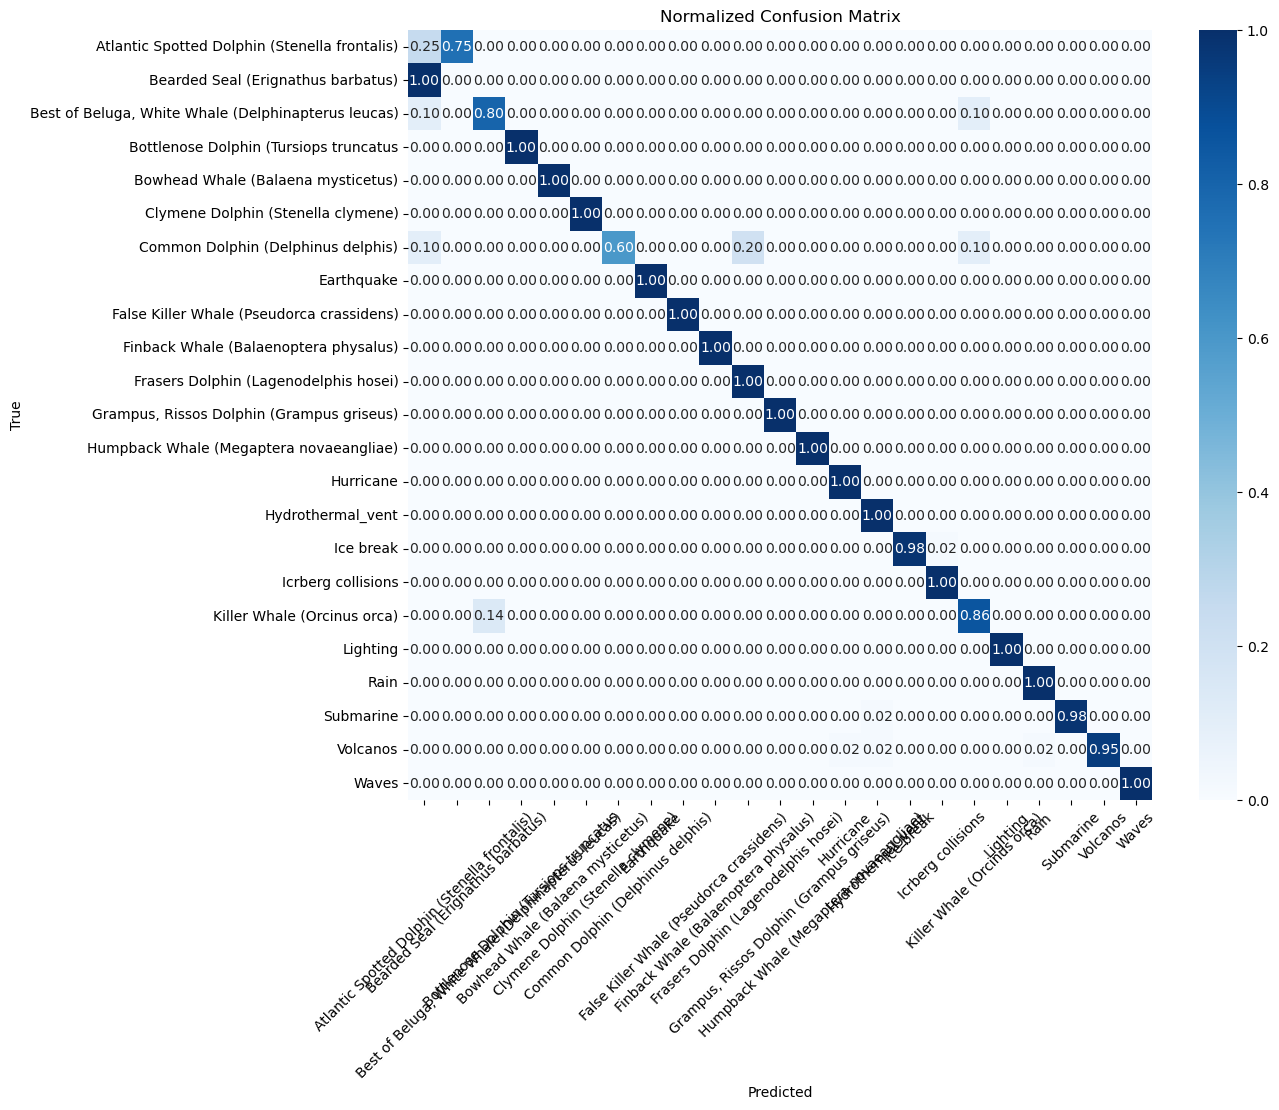


=== Spectrum Management Demonstration ===

Analyzing: 9101301G.wav
Analysis error: Graph execution error:

Detected at node 'model_4/reshape/Reshape' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/opt

In [5]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report)
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.utils import to_categorical
import pandas as pd
import time
import soundfile as sf
import joblib
import hashlib
from sklearn.decomposition import NMF
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

# --------------------------
# 1. Enhanced Audio Data Loader with Caching
# --------------------------

class AudioDataLoader:
    """Handles loading and preprocessing with limit on files per category"""
    
    def __init__(self, target_sr=22050, max_duration=5, n_mfcc=40, cache_dir='./cache', max_files_per_category=100):
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.n_mfcc = n_mfcc
        self.le = LabelEncoder()
        self.supported_formats = ('.wav', '.mp3', '.WAV', '.MP3')
        self.cache_dir = cache_dir
        self.max_files = max_files_per_category
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def _get_cache_path(self, root_path, suffix):
        """Generate cache file path with limit parameter in name"""
        root_hash = hashlib.md5(root_path.encode()).hexdigest()[:8]
        return os.path.join(self.cache_dir, f"{root_hash}_max{self.max_files}_{suffix}")
        
    def is_audio_file(self, filename):
        return filename.lower().endswith(self.supported_formats)
    
    def load_audio_file(self, file_path):
        try:
            # Try librosa first
            try:
                duration = librosa.get_duration(filename=file_path)
                duration = min(duration, self.max_duration)
                audio, sr = librosa.load(
                    file_path,
                    sr=self.target_sr,
                    duration=duration,
                    mono=True,
                    res_type='kaiser_fast'
                )
                return audio, True
            except:
                # Fallback to soundfile
                try:
                    with sf.SoundFile(file_path) as f:
                        duration = min(len(f) / f.samplerate, self.max_duration)
                        target_frames = int(duration * self.target_sr)
                        audio = f.read(frames=target_frames, dtype='float32', always_2d=True)
                        if audio.ndim > 1 and audio.shape[1] > 1:
                            audio = np.mean(audio, axis=1)
                        else:
                            audio = audio.flatten()
                        if f.samplerate != self.target_sr:
                            audio = librosa.resample(audio, orig_sr=f.samplerate, target_sr=self.target_sr)
                        return audio, True
                except Exception as e:
                    print(f"Error loading {file_path}: {str(e)}")
                    return None, False
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            return None, False
    
    def extract_features(self, audio):
        """Enhanced feature extraction with spectrogram support"""
        try:
            features = []
            
            # MFCC features
            mfccs = librosa.feature.mfcc(y=audio, sr=self.target_sr, n_mfcc=self.n_mfcc)
            features.extend(mfccs.flatten())
            
            # Mel spectrogram features
            S = librosa.feature.melspectrogram(y=audio, sr=self.target_sr)
            S_db = librosa.power_to_db(S, ref=np.max)
            features.extend(S_db.flatten())
            
            # Chroma features
            chroma = librosa.feature.chroma_stft(y=audio, sr=self.target_sr)
            features.extend(chroma.flatten())
            
            # Limit feature size for model compatibility
            return np.array(features)[:2048]  # Adjust based on your needs
            
        except Exception as e:
            print(f"Feature extraction error: {str(e)}")
            return None
    
    def load_dataset(self, root_path, use_cache=True):
        features_cache = self._get_cache_path(root_path, "features.npy")
        labels_cache = self._get_cache_path(root_path, "labels.npy")
        paths_cache = self._get_cache_path(root_path, "paths.npy")
        
        if use_cache and all(os.path.exists(f) for f in [features_cache, labels_cache, paths_cache]):
            try:
                print(f"Loading cached data from {features_cache}")
                return np.load(features_cache), np.load(labels_cache), np.load(paths_cache, allow_pickle=True)
            except Exception as e:
                print(f"Error loading cache: {str(e)}. Reprocessing data.")
        
        features, labels, file_paths = [], [], []
        error_count = 0
        total_files = 0
        
        # Count total files first (for progress tracking)
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if os.path.isdir(label_path):
                total_files += min(len([f for f in os.listdir(label_path) if self.is_audio_file(f)]), 
                                self.max_files)
        
        processed_files = 0
        start_time = time.time()
        
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if not os.path.isdir(label_path):
                continue
                
            print(f"\nProcessing category: {label}...")
            files_processed = 0
            
            for file in os.listdir(label_path):
                if not self.is_audio_file(file):
                    continue
                    
                if files_processed >= self.max_files:
                    break
                    
                file_path = os.path.join(label_path, file)
                processed_files += 1
                files_processed += 1
                
                if processed_files % 10 == 0:
                    elapsed = time.time() - start_time
                    remaining = (elapsed/processed_files) * (total_files-processed_files)
                    print(f"  Progress: {processed_files}/{total_files} ({remaining:.1f}s remaining)")
                
                audio, success = self.load_audio_file(file_path)
                if not success:
                    error_count += 1
                    continue
                    
                try:
                    feature_vector = self.extract_features(audio)
                    if feature_vector is not None:
                        features.append(feature_vector)
                        labels.append(label)
                        file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    error_count += 1
        
        # Verify all features have same length before converting to array
        if features:
            feature_length = len(features[0])
            features = [f for f in features if len(f) == feature_length]
            print(f"Final feature vector length: {feature_length}")
            print(f"Number of valid samples: {len(features)}")
            
            features = np.array(features)
            labels = np.array(labels)
            file_paths = np.array(file_paths)
        else:
            features = np.array([])
            labels = np.array([])
            file_paths = np.array([])
        
        if use_cache and len(features) > 0:
            try:
                np.save(features_cache, features)
                np.save(labels_cache, labels)
                np.save(paths_cache, file_paths)
                print(f"Saved processed data to cache: {features_cache}")
            except Exception as e:
                print(f"Error saving cache: {str(e)}")
        
        print(f"\nCompleted loading. Total errors: {error_count}/{total_files}")
        return features, labels, file_paths
    
    def preprocess_data(self, X, y, use_cache=True):
        """Encode labels and scale features with caching"""
        cache_prefix = self._get_cache_path("preprocessed", "")
        
        if use_cache and os.path.exists(cache_prefix + "X_scaled.npy"):
            try:
                print("Loading preprocessed data from cache")
                X_scaled = np.load(cache_prefix + "X_scaled.npy")
                y_categorical = np.load(cache_prefix + "y_categorical.npy")
                self.le = joblib.load(cache_prefix + "label_encoder.joblib")
                scaler = joblib.load(cache_prefix + "scaler.joblib")
                return X_scaled, y_categorical, self.le.classes_
            except Exception as e:
                print(f"Error loading preprocessed cache: {str(e)}. Reprocessing data.")
        
        if len(X) == 0 or len(y) == 0:
            raise ValueError("No valid data to preprocess")
            
        # Encode labels
        y_encoded = self.le.fit_transform(y)
        y_categorical = to_categorical(y_encoded)
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Save to cache
        if use_cache:
            try:
                np.save(cache_prefix + "X_scaled.npy", X_scaled)
                np.save(cache_prefix + "y_categorical.npy", y_categorical)
                joblib.dump(self.le, cache_prefix + "label_encoder.joblib")
                joblib.dump(scaler, cache_prefix + "scaler.joblib")
                print("Saved preprocessed data to cache")
            except Exception as e:
                print(f"Error saving preprocessed cache: {str(e)}")
        
        return X_scaled, y_categorical, self.le.classes_

# --------------------------
# 2. Model Architectures
# --------------------------

class CNNBioAcousticModel:
    """CNN-based model for audio classification"""
    
    def __init__(self, input_shape, num_classes):
        self.model = self.build_model(input_shape, num_classes)
        
    def build_model(self, input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        
        # Reshape for 1D convolutions
        x = layers.Reshape((input_shape[0], 1))(inputs)
        
        # CNN Block 1
        x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        
        # CNN Block 2
        x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        
        # CNN Block 3
        x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling1D()(x)
        
        # Output
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.AUC(name='auc')]
        )
        return model

class ViTBioAcousticModel:
    """Vision Transformer for audio classification"""
    
    def __init__(self, input_shape, num_classes, num_heads=4, ff_dim=256, num_transformer_blocks=4):
        self.model = self.build_model(input_shape, num_classes, num_heads, ff_dim, num_transformer_blocks)
        
    def build_model(self, input_shape, num_classes, num_heads, ff_dim, num_transformer_blocks):
        inputs = layers.Input(shape=input_shape)
        
        # Convert features to image-like representation
        x = layers.Reshape((input_shape[0]//16, 16, 1))(inputs)
        
        # Patch embedding
        patch_size = 4
        num_patches = (x.shape[1] * x.shape[2]) // (patch_size ** 2)
        x = layers.Conv2D(64, kernel_size=patch_size, strides=patch_size)(x)
        x = layers.Reshape((num_patches, 64))(x)
        
        # Position embedding
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(input_dim=num_patches, output_dim=64)(positions)
        x = x + position_embedding
        
        # Transformer blocks
        for _ in range(num_transformer_blocks):
            # Layer normalization 1
            x1 = LayerNormalization(epsilon=1e-6)(x)
            
            # Multi-head attention
            attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=64)(x1, x1)
            
            # Skip connection 1
            x = layers.Add()([attention_output, x])
            
            # Layer normalization 2
            x2 = LayerNormalization(epsilon=1e-6)(x)
            
            # MLP
            x2 = layers.Dense(ff_dim, activation="gelu")(x2)
            x2 = layers.Dense(64)(x2)
            
            # Skip connection 2
            x = layers.Add()([x2, x])
        
        # Classification head
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.GlobalAveragePooling1D()(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.AUC(name='auc')]
        )
        return model

class HybridBioAcousticModel:
    """Combines CNN and Transformer architectures"""
    
    def __init__(self, input_shape, num_classes):
        self.model = self.build_model(input_shape, num_classes)
        
    def build_model(self, input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        
        # CNN Branch
        cnn_branch = layers.Reshape((input_shape[0], 1))(inputs)
        cnn_branch = layers.Conv1D(64, 3, activation='relu', padding='same')(cnn_branch)
        cnn_branch = layers.BatchNormalization()(cnn_branch)
        cnn_branch = layers.MaxPooling1D(2)(cnn_branch)
        cnn_branch = layers.Conv1D(128, 3, activation='relu', padding='same')(cnn_branch)
        cnn_branch = layers.GlobalAveragePooling1D()(cnn_branch)
        
        # Transformer Branch (simplified)
        transformer_branch = layers.Reshape((input_shape[0]//16, 16))(inputs)
        transformer_branch = layers.MultiHeadAttention(num_heads=4, key_dim=64)(transformer_branch, transformer_branch)
        transformer_branch = layers.GlobalAveragePooling1D()(transformer_branch)
        
        # Original Dense Branch
        dense_branch = layers.Dense(256, activation='relu')(inputs)
        dense_branch = layers.BatchNormalization()(dense_branch)
        
        # Concatenate all branches
        merged = layers.Concatenate()([cnn_branch, transformer_branch, dense_branch])
        
        # Additional processing
        x = layers.Dense(256, activation='relu')(merged)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy', 
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.AUC(name='auc')]
        )
        return model

# --------------------------
# 3. Evaluation & Visualization
# --------------------------

class ResultVisualizer:
    """Enhanced visualization with more metrics"""
    
    @staticmethod
    def plot_training_history(history):
        """Plot training and validation metrics"""
        metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
        plt.figure(figsize=(15, 12))
        
        for i, metric in enumerate(metrics):
            plt.subplot(3, 2, i+1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(f'Model {metric.capitalize()}')
            plt.ylabel(metric.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names):
        """Enhanced confusion matrix visualization"""
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.show()
    
    @staticmethod
    def plot_spectral_features(audio_path, sr=22050):
        """Enhanced spectral feature visualization"""
        y, sr = librosa.load(audio_path, sr=sr)
        
        plt.figure(figsize=(15, 10))
        
        # Waveform
        plt.subplot(3, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title('Audio Waveform')
        
        # Spectrogram
        plt.subplot(3, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Log-frequency power spectrogram')
        
        # MFCCs
        plt.subplot(3, 1, 3)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        
        plt.tight_layout()
        plt.show()

# --------------------------
# 4. Spectrum Management System
# --------------------------

class SpectrumManager:
    """Enhanced spectrum allocation with priority management"""
    
    def __init__(self, classifier, label_encoder):
        self.classifier = classifier
        self.label_encoder = label_encoder
        self.band_allocation = {
            'infrasonic': (1, 20),    # Earthquakes
            'low': (20, 500),        # Hurricanes, waves
            'mid': (500, 20000),      # Marine mammals
            'high': (20000, 40000)    # Backup
        }
        self.current_allocations = []
        self.priority_map = {
            'dolphin': 3,    # Highest priority
            'whale': 3,
            'minke_whale': 3,
            'hurricane': 2,
            'earthquake': 1,  # Lowest priority
            'wave': 1
        }
        
    def analyze_audio(self, audio):
        """Enhanced audio analysis with error handling"""
        try:
            # Extract features
            loader = AudioDataLoader()
            features = loader.extract_features(audio)
            if features is None:
                return None, None
                
            features = np.array(features).reshape(1, -1)
            
            # Classify
            pred = self.classifier.predict(features)
            class_idx = np.argmax(pred)
            sound_class = self.label_encoder[class_idx]
            
            # Frequency analysis
            freqs = np.fft.rfftfreq(len(audio), d=1/22050)
            fft = np.abs(np.fft.rfft(audio))
            
            band_energy = {}
            for band, (low, high) in self.band_allocation.items():
                mask = (freqs >= low) & (freqs <= high)
                band_energy[band] = np.sum(fft[mask])
            
            return sound_class, band_energy
        except Exception as e:
            print(f"Analysis error: {str(e)}")
            return None, None
    
    def allocate_band(self, sound_class, band_energy):
        """Enhanced allocation with priority system"""
        if sound_class not in self.priority_map:
            sound_class = 'other'
            
        allocation = {
            'primary': None,
            'secondary': None,
            'priority': self.priority_map.get(sound_class, 0)
        }
        
        # Priority-based allocation
        if sound_class in ['dolphin', 'whale', 'minke_whale']:
            allocation['primary'] = 'mid'
            allocation['secondary'] = 'high'
        elif sound_class == 'earthquake':
            allocation['primary'] = 'infrasonic'
        elif sound_class == 'hurricane':
            # Dynamic allocation based on current usage
            if band_energy['mid'] > 0.5 * band_energy['low']:
                allocation['primary'] = 'low'
            else:
                allocation['primary'] = 'mid'
        else:
            # Default allocation for unknown classes
            allocation['primary'] = 'low'
            
        return allocation
    
    def visualize_allocation(self):
        """Enhanced visualization with priority information"""
        if not self.current_allocations:
            print("No allocations to visualize")
            return
            
        plt.figure(figsize=(12, 8))
        
        # Create a color map based on priority
        colors = {1: 'lightblue', 2: 'orange', 3: 'red'}
        
        for alloc in self.current_allocations:
            band_range = self.band_allocation[alloc['band']]
            plt.barh(
                alloc['class'], 
                width=band_range[1]-band_range[0],
                left=band_range[0],
                alpha=0.6,
                color=colors.get(alloc['priority'], 'gray'),
                label=f"{alloc['class']} (Priority {alloc['priority']})"
            )
        
        plt.title('Current Spectrum Allocation with Priority')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Sound Class')
        plt.xscale('log')
        plt.grid(True, which="both", ls="--")
        
        # Create custom legend
        handles = [
            plt.Rectangle((0,0),1,1, color='red', alpha=0.6, label='High Priority (Marine Mammals)'),
            plt.Rectangle((0,0),1,1, color='orange', alpha=0.6, label='Medium Priority (Weather)'),
            plt.Rectangle((0,0),1,1, color='lightblue', alpha=0.6, label='Low Priority (Geophonic)')
        ]
        plt.legend(handles=handles)
        
        plt.show()

# --------------------------
# 5. Main Execution
# --------------------------

def main():
    print("=== Marine Bioacoustic Classification System ===")
    
    # Initialize with max 100 files per category
    loader = AudioDataLoader(
        target_sr=44100,
        max_duration=4,
        n_mfcc=60,
        cache_dir='./audio_cache',
        max_files_per_category=300
    )
    
    # Load datasets
    print("\nLoading biophonic dataset...")
    bio_X, bio_y, bio_paths = loader.load_dataset(
        "/Users/fatbatman/Develop/Liquid Neural Network/dataset",
        use_cache=True
    )
    
    print("\nLoading geophonic dataset...")
    geo_X, geo_y, geo_paths = loader.load_dataset(
        "/Users/fatbatman/Downloads/Dataset",
        use_cache=True
    )
    
    if len(bio_X) == 0 or len(geo_X) == 0:
        print("Error: No valid data loaded. Check your dataset paths and file formats.")
        return
    
    # Combine and preprocess data with caching
    print("\nPreprocessing data...")
    X = np.concatenate((bio_X, geo_X))
    y = np.concatenate((bio_y, geo_y))
    
    try:
        X_scaled, y_categorical, class_names = loader.preprocess_data(X, y, use_cache=True)
    except ValueError as e:
        print(f"Preprocessing error: {str(e)}")
        return
    
    # Split data with stratification
    print("\nSplitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_categorical, 
        test_size=0.2, 
        random_state=42,
        stratify=y_categorical
    )
    
    # Model selection
    print("\nAvailable models:")
    print("1. CNN Model")
    print("2. Vision Transformer (ViT) Model")
    print("3. Hybrid Model (CNN + Transformer)")
    choice = input("Select model (1-3): ")
    
    if choice == '1':
        print("\nTraining CNN model...")
        model = CNNBioAcousticModel(
            input_shape=(X_train.shape[1],), 
            num_classes=len(class_names)
        )
    elif choice == '2':
        print("\nTraining Vision Transformer model...")
        model = ViTBioAcousticModel(
            input_shape=(X_train.shape[1],), 
            num_classes=len(class_names)
        )
    else:
        print("\nTraining Hybrid model...")
        model = HybridBioAcousticModel(
            input_shape=(X_train.shape[1],), 
            num_classes=len(class_names)
        )
    
    # Train model
    history = model.model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=150,
        batch_size=64,
        callbacks=[
            callbacks.EarlyStopping(patience=15, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
        ]
    )
    
    # Evaluate model
    print("\nEvaluating model performance...")
    y_pred = model.model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    print(f"\n=== Final Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    
    # Visualizations
    visualizer = ResultVisualizer()
    visualizer.plot_training_history(history)
    visualizer.plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)
    
    # Spectrum management demonstration
    print("\n=== Spectrum Management Demonstration ===")
    spectrum_manager = SpectrumManager(model.model, class_names)
    
    # Analyze sample files
    sample_paths = [
        np.random.choice(bio_paths),  # Random biophonic sample
        np.random.choice(geo_paths)   # Random geophonic sample
    ]
    
    for path in sample_paths:
        print(f"\nAnalyzing: {os.path.basename(path)}")
        
        # Load and analyze
        audio, _ = librosa.load(path, sr=44100, duration=4)
        sound_class, band_energy = spectrum_manager.analyze_audio(audio)
        
        if sound_class is None:
            print("Analysis failed for this sample")
            continue
            
        allocation = spectrum_manager.allocate_band(sound_class, band_energy)
        
        print(f"Classified as: {sound_class}")
        print("Band Energy Distribution:")
        for band, energy in band_energy.items():
            print(f"  {band}: {energy:.2f}")
        print("Allocation:", allocation)
        
        # Add to current allocations
        spectrum_manager.current_allocations.append({
            'class': sound_class,
            'band': allocation['primary'],
            'priority': allocation['priority'],
            'energy': band_energy[allocation['primary']]
        })
        
        # Visualize sample features
        visualizer.plot_spectral_features(path)
    
    # Show final spectrum allocation
    spectrum_manager.visualize_allocation()

if __name__ == "__main__":
    main()

Processing biophonic dataset...
Loading cached results from ./freq_cache/freq_analysis_7b081655.joblib

Processing geophonic dataset...
Loading cached results from ./freq_cache/freq_analysis_1ad7540f.joblib


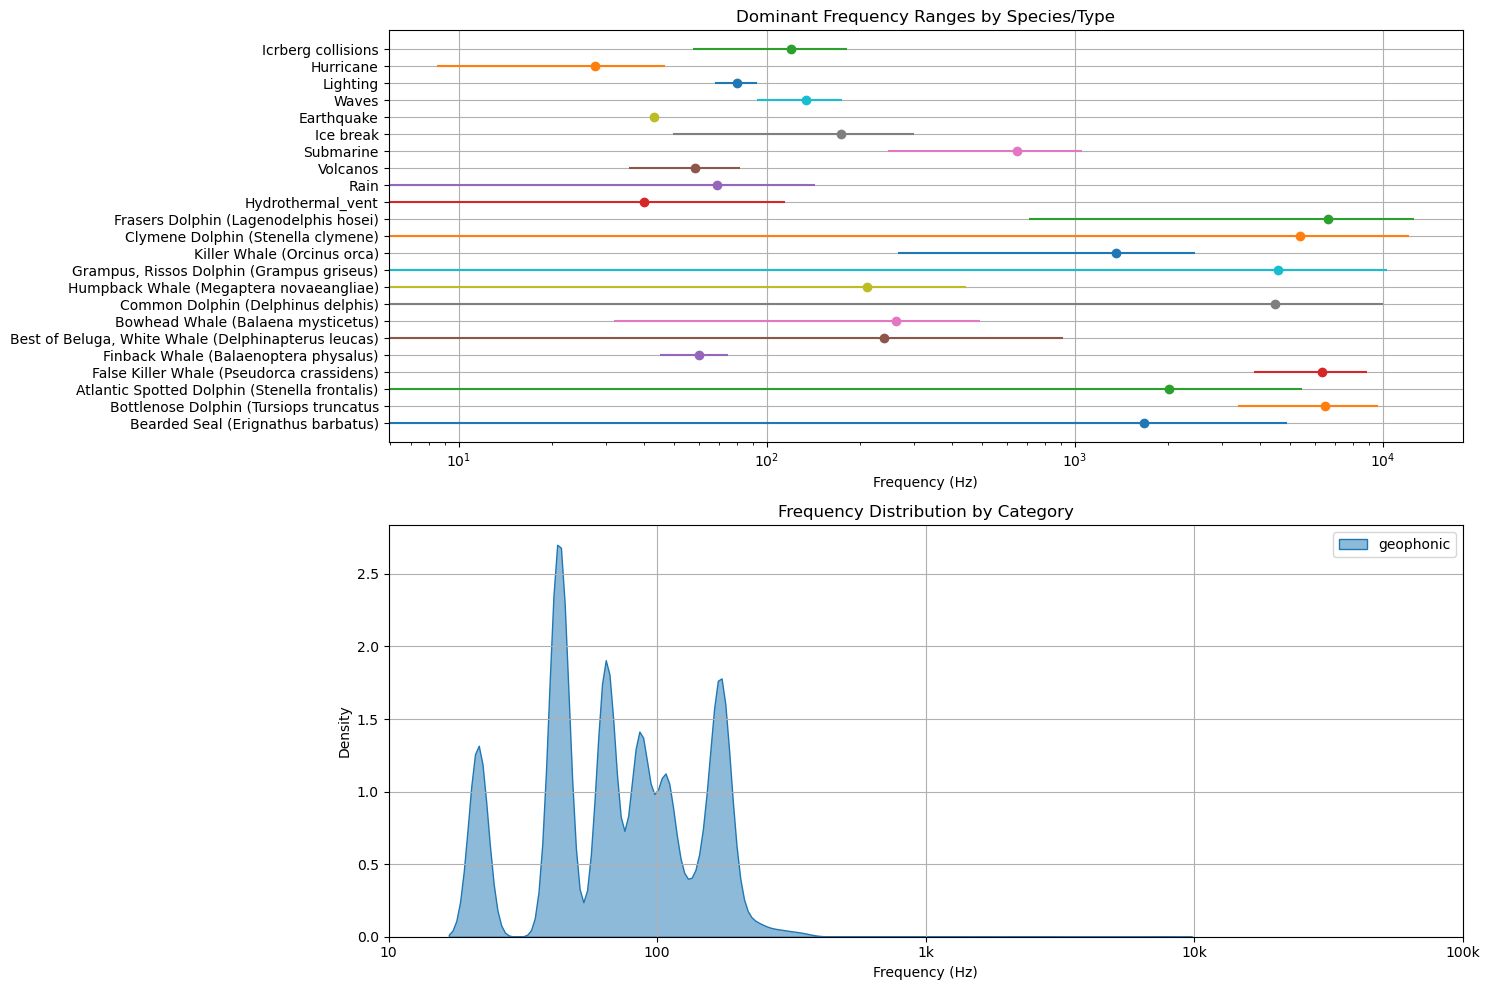


=== Individual Frequency Summary ===
                                                      mean_freq     std_freq  \
Bearded Seal (Erignathus barbatus)                  1676.898193  3215.985344   
Bottlenose Dolphin (Tursiops truncatus              6503.027344  3125.802369   
Atlantic Spotted Dolphin (Stenella frontalis)       2018.737793  3450.723395   
False Killer Whale (Pseudorca crassidens)           6331.168006  2523.336853   
Finback Whale (Balaenoptera physalus)                 60.066303    14.949603   
Best of Beluga, White Whale (Delphinapterus leu...   239.312189   673.285855   
Bowhead Whale (Balaena mysticetus)                   262.055019   230.243874   
Common Dolphin (Delphinus delphis)                  4448.643370  5541.320029   
Humpback Whale (Megaptera novaeangliae)              211.871338   231.697408   
Grampus, Rissos Dolphin (Grampus griseus)           4552.183419  5725.407867   
Killer Whale (Orcinus orca)                         1360.506925  1094.437557   
Cl

In [15]:
import os
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import hashlib
from collections import defaultdict
import seaborn as sns

class FrequencyAnalyzer:
    """Analyzes frequency characteristics of bioacoustic and geophonic sounds"""
    
    def __init__(self, target_sr=44100, max_duration=4, cache_dir='./freq_cache'):
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def _get_cache_path(self, root_path):
        """Generate cache file path based on dataset path"""
        root_hash = hashlib.md5(root_path.encode()).hexdigest()[:8]
        return os.path.join(self.cache_dir, f"freq_analysis_{root_hash}.joblib")
    
    def _compute_psd(self, y):
        """Compute power spectral density with validation"""
        try:
            n_fft = min(2048, len(y))
            if n_fft < 8:  # Minimum FFT size
                return np.array([]), np.array([])
                
            psd = np.abs(librosa.stft(y, n_fft=n_fft))**2
            psd = np.mean(psd, axis=1)  # Average over time
            freqs = librosa.fft_frequencies(sr=self.target_sr, n_fft=n_fft)
            return freqs, psd
        except Exception:
            return np.array([]), np.array([])
    
    def _compute_bandwidth(self, freqs, psd, threshold=-3):
        """Compute bandwidth with validation"""
        if len(freqs) == 0 or len(psd) == 0:
            return 0.0
            
        try:
            peak_idx = np.argmax(psd)
            peak_power = 10 * np.log10(psd[peak_idx])
            
            # Find lower cutoff
            lower_idx = peak_idx
            while lower_idx > 0 and (10 * np.log10(psd[lower_idx]) > peak_power + threshold):
                lower_idx -= 1
                
            # Find upper cutoff
            upper_idx = peak_idx
            while upper_idx < len(psd)-1 and (10 * np.log10(psd[upper_idx]) > peak_power + threshold):
                upper_idx += 1
                
            return freqs[upper_idx] - freqs[lower_idx]
        except Exception:
            return 0.0
    
    def analyze_directory(self, root_path, category_hint=None, use_cache=True):
        """Analyze all audio files in directory structure with explicit category hint"""
        cache_path = self._get_cache_path(root_path)
        
        if use_cache and os.path.exists(cache_path):
            print(f"Loading cached results from {cache_path}")
            return joblib.load(cache_path)
            
        results = {
            'individual': defaultdict(list),
            'category': defaultdict(list)
        }
        
        # Determine category explicitly if not provided
        if category_hint is None:
            if 'bio' in root_path.lower():
                category = 'biophonic'
            elif 'geo' in root_path.lower():
                category = 'geophonic'
            else:
                category = 'unknown'
        else:
            category = category_hint
        
        # Process files (same as before but with explicit category)
        audio_files = [f for f in os.listdir(root_path) if f.lower().endswith(('.wav', '.mp3', '.WAV', '.MP3'))]
        
        if audio_files:
            label = os.path.basename(root_path)
            print(f"\nProcessing {label} ({category})...")
            valid_files = self._process_files(root_path, audio_files, label, category, results)
            
            if valid_files == 0:
                print(f"Warning: No valid files found in {root_path}")
        else:
            for entry in os.listdir(root_path):
                entry_path = os.path.join(root_path, entry)
                if os.path.isdir(entry_path):
                    sub_audio_files = [f for f in os.listdir(entry_path) if f.lower().endswith(('.wav', '.mp3', '.WAV', '.MP3'))]
                    if sub_audio_files:
                        label = entry
                        print(f"\nProcessing {label} ({category})...")
                        valid_files = self._process_files(entry_path, sub_audio_files, label, category, results)
                        
                        if valid_files == 0:
                            print(f"Warning: No valid files found in {entry_path}")
        
        if use_cache and (results['individual'] or results['category']):
            joblib.dump(results, cache_path)
            print(f"Saved results to cache: {cache_path}")
            
        return results
    
    def _process_files(self, dir_path, files, label, category, results):
        """Process a batch of files in a directory"""
        valid_files = 0
        
        for file in tqdm(files, desc=label):
            file_path = os.path.join(dir_path, file)
            
            try:
                # Load audio with duration limit
                y, sr = librosa.load(file_path, sr=self.target_sr, 
                                    duration=self.max_duration)
                
                if len(y) == 0:
                    continue
                
                # Compute frequency characteristics
                freqs, psd = self._compute_psd(y)
                if len(freqs) == 0 or len(psd) == 0:
                    continue
                
                dominant_freq = freqs[np.argmax(psd)]
                bandwidth = self._compute_bandwidth(freqs, psd)
                
                # Store results
                result = {
                    'dominant_freq': dominant_freq,
                    'bandwidth': bandwidth,
                    'freq_range': (freqs[0], freqs[-1]),
                    'psd': psd,
                    'file': file_path
                }
                
                results['individual'][label].append(result)
                results['category'][category].append(result)
                valid_files += 1
                
            except Exception as e:
                print(f"Error processing {file_path}: {str(e)}")
        
        return valid_files
    
    def generate_summary(self, results):
        """Generate summary statistics with empty data handling"""
        summary = {
            'individual': {},
            'category': {}
        }
        
        # Individual species/type summaries
        for label, data in results['individual'].items():
            if not data:
                continue
                
            # Filter out zero frequencies
            freqs = [d['dominant_freq'] for d in data if 'dominant_freq' in d and d['dominant_freq'] > 0]
            bws = [d['bandwidth'] for d in data if 'bandwidth' in d and d['bandwidth'] > 0]
            
            if not freqs or not bws:
                continue
                
            summary['individual'][label] = {
                'mean_freq': np.mean(freqs) if freqs else 0,
                'std_freq': np.std(freqs) if freqs else 0,
                'min_freq': np.min(freqs) if freqs else 0,
                'max_freq': np.max(freqs) if freqs else 0,
                'mean_bw': np.mean(bws) if bws else 0,
                'count': len(data)
            }
        
        # Category summaries (biophonic/geophonic)
        for category, data in results['category'].items():
            if not data:
                continue
                
            # Filter out zero frequencies
            freqs = [d['dominant_freq'] for d in data if 'dominant_freq' in d and d['dominant_freq'] > 0]
            bws = [d['bandwidth'] for d in data if 'bandwidth' in d and d['bandwidth'] > 0]
            
            if not freqs or not bws:
                continue
                
            summary['category'][category] = {
                'mean_freq': np.mean(freqs) if freqs else 0,
                'std_freq': np.std(freqs) if freqs else 0,
                'min_freq': np.min(freqs) if freqs else 0,
                'max_freq': np.max(freqs) if freqs else 0,
                'mean_bw': np.mean(bws) if bws else 0,
                'count': len(data)
            }
            
        return summary
    
    def visualize_results(self, results, summary):
        """Generate visualization plots with empty data handling"""
        if not summary['individual'] and not summary['category']:
            print("No valid data to visualize")
            return
            
        plt.figure(figsize=(15, 10))
        
        # Plot individual species frequency ranges
        if summary['individual']:
            plt.subplot(2, 1, 1)
            for label, stats in summary['individual'].items():
                if stats['count'] == 0:
                    continue
                plt.errorbar(
                    x=stats['mean_freq'],
                    y=label,
                    xerr=stats['std_freq'],
                    fmt='o',
                    label=label
                )
            plt.xscale('log')
            plt.title('Dominant Frequency Ranges by Species/Type')
            plt.xlabel('Frequency (Hz)')
            plt.grid(True)
        
        # Plot category density
        if results['category']:
            plt.subplot(2, 1, 2)
            for category, data in results['category'].items():
                if not data:
                    continue
                freqs = [d['dominant_freq'] for d in data if 'dominant_freq' in d]
                if not freqs:
                    continue
                sns.kdeplot(
                    np.log10(freqs),
                    label=category,
                    fill=True,
                    alpha=0.5
                )
            plt.xticks(
                np.log10([10, 100, 1000, 10000, 100000]),
                ['10', '100', '1k', '10k', '100k']
            )
            plt.title('Frequency Distribution by Category')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Density')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# In the main() function, modify the results combination part:

def main():
    analyzer = FrequencyAnalyzer()
    
    # Explicitly specify categories
    bio_path = "/Users/fatbatman/Develop/Liquid Neural Network/dataset"
    geo_path = "/Users/fatbatman/Downloads/Dataset"
    
    print("Processing biophonic dataset...")
    bio_results = analyzer.analyze_directory(bio_path, category_hint='biophonic')
    
    print("\nProcessing geophonic dataset...")
    geo_results = analyzer.analyze_directory(geo_path, category_hint='geophonic')
    
    # Combine results - Modified to properly handle both categories
    combined_results = {
        'individual': {**bio_results['individual'], **geo_results['individual']},
        'category': {
            'biophonic': bio_results['category']['biophonic'] if 'biophonic' in bio_results['category'] else [],
            'geophonic': geo_results['category']['geophonic'] if 'geophonic' in geo_results['category'] else []
        }
    }
    
    # Generate and display summaries
    combined_summary = analyzer.generate_summary(combined_results)
    
    # Save results - Ensure both categories are saved
    if combined_summary['individual']:
        pd.DataFrame(combined_summary['individual']).T.to_csv('individual_frequencies.csv')
    
    if combined_summary['category']:
        # Create a DataFrame that includes both categories
        category_data = {
            'biophonic': combined_summary['category'].get('biophonic', {}),
            'geophonic': combined_summary['category'].get('geophonic', {})
        }
        pd.DataFrame(category_data).T.to_csv('category_frequencies.csv')
    
    # Visualize
    analyzer.visualize_results(combined_results, combined_summary)
    
    # Print summaries
    if combined_summary['individual']:
        print("\n=== Individual Frequency Summary ===")
        print(pd.DataFrame(combined_summary['individual']).T)
    
    if combined_summary['category']:
        print("\n=== Category Frequency Summary ===")
        # Print both categories explicitly
        if 'biophonic' in combined_summary['category']:
            print("\nBiophonic Summary:")
            print(pd.Series(combined_summary['category']['biophonic']))
        if 'geophonic' in combined_summary['category']:
            print("\nGeophonic Summary:")
            print(pd.Series(combined_summary['category']['geophonic']))

if __name__ == "__main__":
    main()

In [ ]:


# Usage example in main():
def main():
    # ... [previous code] ...
    
    # After getting frequency stats
    frequency_stats = {
        'individual': {
            # This would be populated from your CSV/data
            'Bearded Seal (Erignathus barbatus)': {
                'mean_freq': 773.95,
                'std_freq': 2339.30,
                'min_freq': 0.0,
                'max_freq': 8031.88,
                'mean_bw': 52.18,
                'count': 52
            },
            # Add all other species similarly
            # ...
        },
        'category': {
            'biophonic': [...],
            'geophonic': [...]
        }
    }
    
    # Initialize SpectrumManager with frequency stats
    spectrum_manager = SpectrumManager(
        classifier.model,
        class_names,
        frequency_stats
    )
    
    # ... [rest of your code] ...

=== Marine Bioacoustic and Geophonic Sound Classification ===

Loading biophonic dataset (max 100 files per category)...
Loading cached data from ./audio_cache/7b081655_max300_features.npy

Loading geophonic dataset (max 100 files per category)...
Loading cached data from ./audio_cache/1ad7540f_max300_features.npy

Preprocessing data...
Loading preprocessed data from cache

Splitting data...

Training model...
Epoch 1/150
47/47 [==============================] - 1s 11ms/step - loss: 1.0421 - accuracy: 0.7855 - precision: 0.8869 - recall: 0.7518 - auc: 0.9547 - val_loss: 0.6502 - val_accuracy: 0.8831 - val_precision: 0.9473 - val_recall: 0.7245 - val_auc: 0.9855 - lr: 0.0010
Epoch 2/150
47/47 [==============================] - 0s 4ms/step - loss: 0.2824 - accuracy: 0.9250 - precision: 0.9531 - recall: 0.9092 - auc: 0.9929 - val_loss: 0.3310 - val_accuracy: 0.9086 - val_precision: 0.9535 - val_recall: 0.8817 - val_auc: 0.9936 - lr: 0.0010
Epoch 3/150
47/47 [==============================

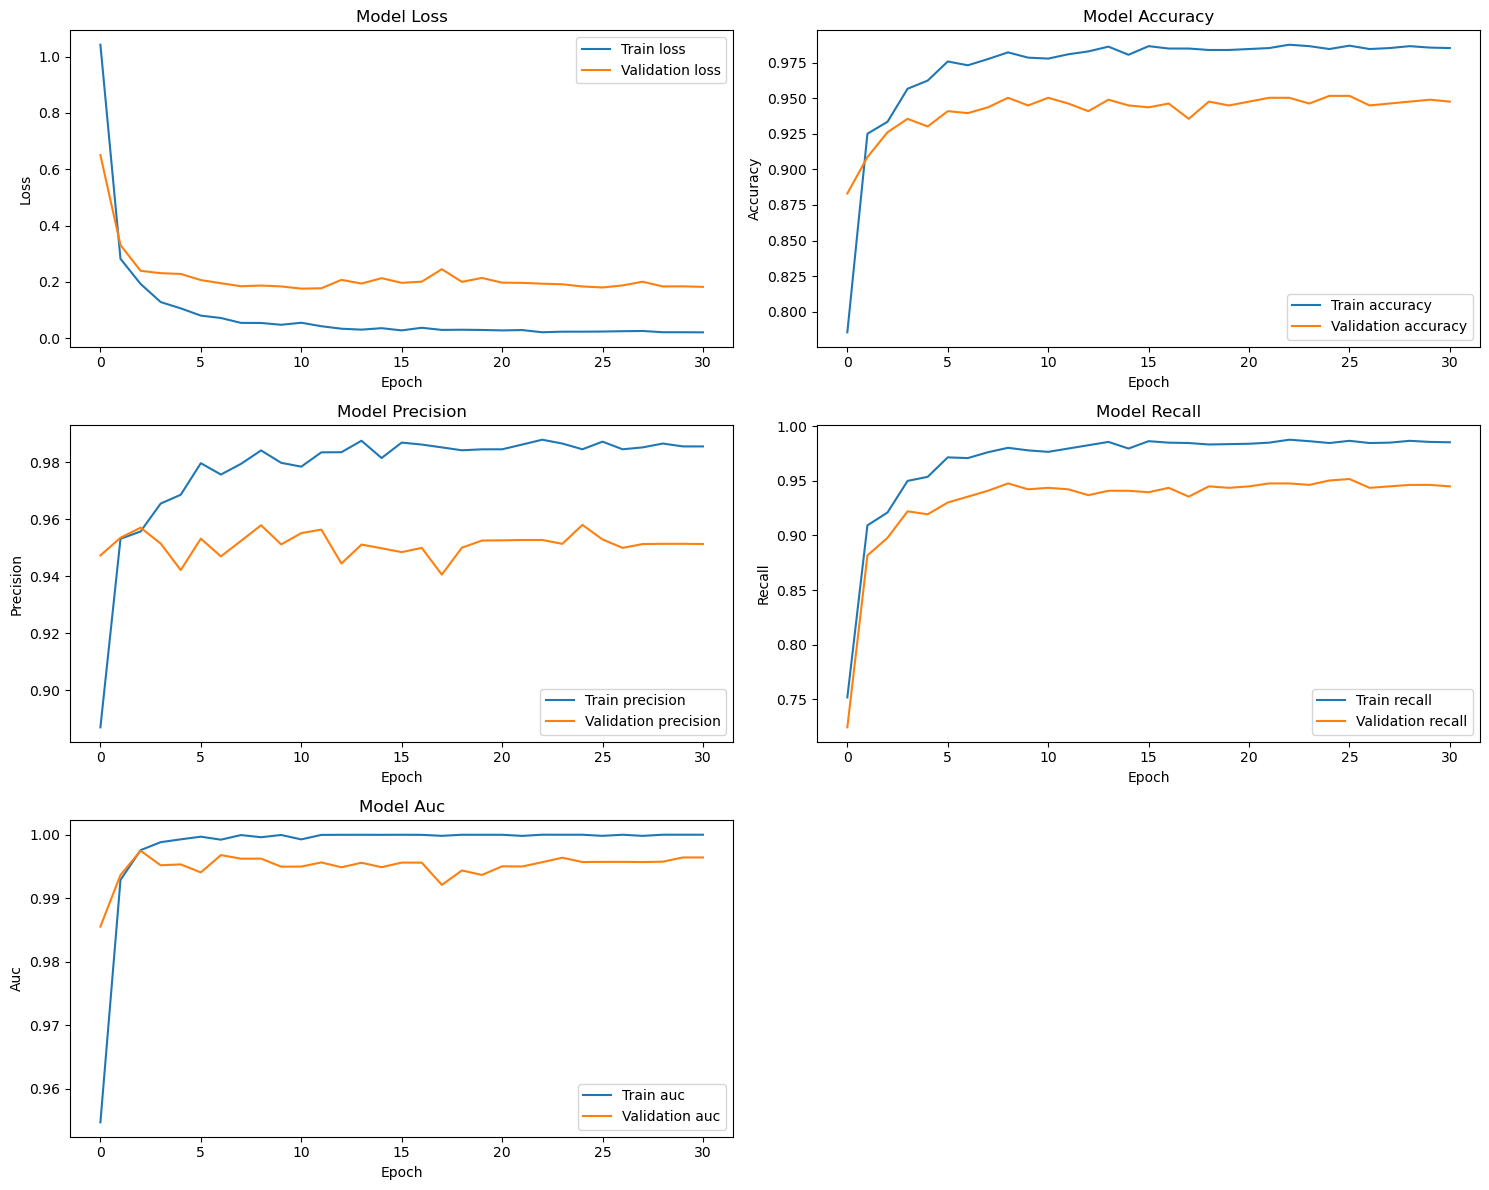

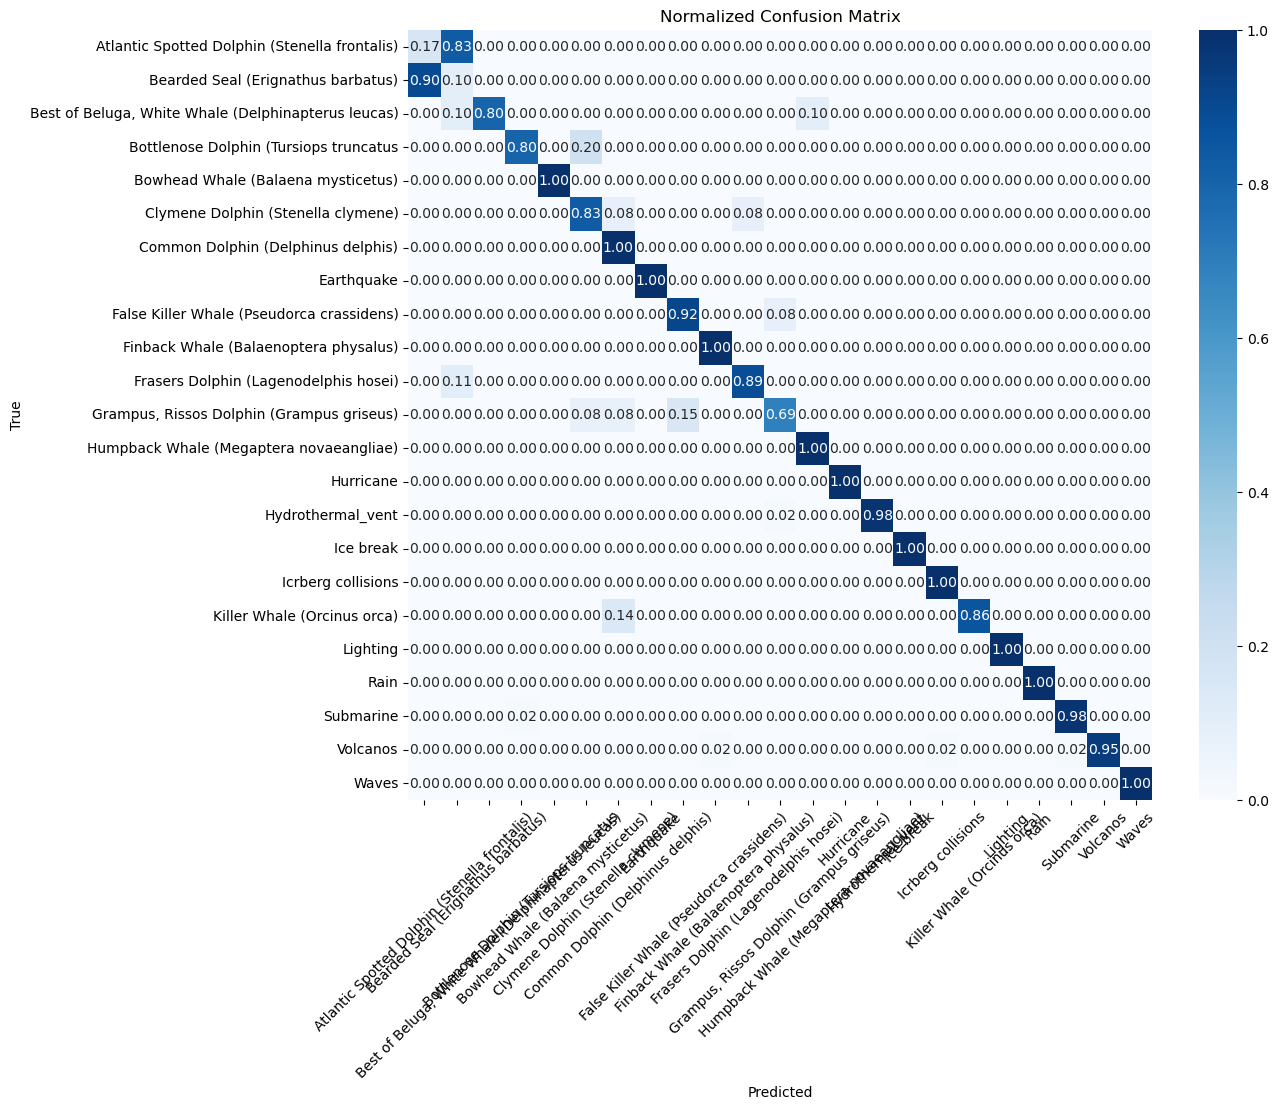


=== Spectrum Management Demonstration ===

Analyzing: 61079006.wav
Analysis error: Graph execution error:

Detected at node 'model_3/dense_23/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/opt/h

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report)
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import pandas as pd
import time
import soundfile as sf
import joblib
import hashlib
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Enhanced Audio Data Loader with Caching (from original code)
# --------------------------

class AudioDataLoader:
    """Handles loading and preprocessing with limit on files per category"""
    
    def __init__(self, target_sr=22050, max_duration=5, n_mfcc=40, cache_dir='./cache', max_files_per_category=100):
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.n_mfcc = n_mfcc
        self.le = LabelEncoder()
        self.supported_formats = ('.wav', '.mp3', '.WAV', '.MP3')
        self.cache_dir = cache_dir
        self.max_files = max_files_per_category
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def _get_cache_path(self, root_path, suffix):
        """Generate cache file path with limit parameter in name"""
        root_hash = hashlib.md5(root_path.encode()).hexdigest()[:8]
        return os.path.join(self.cache_dir, f"{root_hash}_max{self.max_files}_{suffix}")
        
    def is_audio_file(self, filename):
        return filename.lower().endswith(self.supported_formats)
    
    def load_audio_file(self, file_path):
        try:
            # Try librosa first
            try:
                duration = librosa.get_duration(filename=file_path)
                duration = min(duration, self.max_duration)
                audio, sr = librosa.load(
                    file_path,
                    sr=self.target_sr,
                    duration=duration,
                    mono=True,
                    res_type='kaiser_fast'
                )
                return audio, True
            except:
                # Fallback to soundfile
                try:
                    with sf.SoundFile(file_path) as f:
                        duration = min(len(f) / f.samplerate, self.max_duration)
                        target_frames = int(duration * self.target_sr)
                        audio = f.read(frames=target_frames, dtype='float32', always_2d=True)
                        if audio.ndim > 1 and audio.shape[1] > 1:
                            audio = np.mean(audio, axis=1)
                        else:
                            audio = audio.flatten()
                        if f.samplerate != self.target_sr:
                            audio = librosa.resample(audio, orig_sr=f.samplerate, target_sr=self.target_sr)
                        return audio, True
                except Exception as e:
                    print(f"Error loading {file_path}: {str(e)}")
                    return None, False
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            return None, False
    
    def load_dataset(self, root_path, use_cache=True):
        features_cache = self._get_cache_path(root_path, "features.npy")
        labels_cache = self._get_cache_path(root_path, "labels.npy")
        paths_cache = self._get_cache_path(root_path, "paths.npy")
        
        if use_cache and all(os.path.exists(f) for f in [features_cache, labels_cache, paths_cache]):
            try:
                print(f"Loading cached data from {features_cache}")
                return np.load(features_cache), np.load(labels_cache), np.load(paths_cache, allow_pickle=True)
            except Exception as e:
                print(f"Error loading cache: {str(e)}. Reprocessing data.")
        
        features, labels, file_paths = [], [], []
        error_count = 0
        total_files = 0
        
        # Count total files first (for progress tracking)
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if os.path.isdir(label_path):
                total_files += min(len([f for f in os.listdir(label_path) if self.is_audio_file(f)]), 
                                self.max_files)
        
        processed_files = 0
        start_time = time.time()
        
        for label in os.listdir(root_path):
            label_path = os.path.join(root_path, label)
            if not os.path.isdir(label_path):
                continue
                
            print(f"\nProcessing category: {label}...")
            files_processed = 0
            
            for file in os.listdir(label_path):
                if not self.is_audio_file(file):
                    continue
                    
                # Enforce file limit per category
                if files_processed >= self.max_files:
                    break
                    
                file_path = os.path.join(label_path, file)
                processed_files += 1
                files_processed += 1
                
                if processed_files % 10 == 0:
                    elapsed = time.time() - start_time
                    remaining = (elapsed/processed_files) * (total_files-processed_files)
                    print(f"  Progress: {processed_files}/{total_files} ({remaining:.1f}s remaining)")
                
                audio, success = self.load_audio_file(file_path)
                if not success:
                    error_count += 1
                    continue
                    
                try:
                    feature_vector = self.extract_features(audio)
                    if feature_vector is not None:  # Only add if feature extraction succeeded
                        features.append(feature_vector)
                        labels.append(label)
                        file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    error_count += 1
        
        # Verify all features have same length before converting to array
        if features:
            feature_length = len(features[0])
            features = [f for f in features if len(f) == feature_length]
            print(f"Final feature vector length: {feature_length}")
            print(f"Number of valid samples: {len(features)}")
            
            features = np.array(features)
            labels = np.array(labels)
            file_paths = np.array(file_paths)
        else:
            features = np.array([])
            labels = np.array([])
            file_paths = np.array([])
        
        if use_cache and len(features) > 0:
            try:
                np.save(features_cache, features)
                np.save(labels_cache, labels)
                np.save(paths_cache, file_paths)
                print(f"Saved processed data to cache: {features_cache}")
            except Exception as e:
                print(f"Error saving cache: {str(e)}")
        
        print(f"\nCompleted loading. Total errors: {error_count}/{total_files}")
        return features, labels, file_paths

    def extract_features(self, audio):
        """Extract comprehensive audio features with consistent length"""
        try:
            features = []
            
            # MFCCs with delta features (always produces n_mfcc coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=self.target_sr, n_mfcc=self.n_mfcc)
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2)
            
            # Always take first n_mfcc coefficients for each
            features.extend(np.mean(mfccs, axis=1)[:self.n_mfcc])
            features.extend(np.std(mfccs, axis=1)[:self.n_mfcc])
            features.extend(np.mean(delta_mfccs, axis=1)[:self.n_mfcc])
            features.extend(np.mean(delta2_mfccs, axis=1)[:self.n_mfcc])
            
            # Spectral features (fixed number)
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=self.target_sr)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=self.target_sr)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=self.target_sr)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(spectral_centroid), np.std(spectral_centroid),
                np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
                *np.mean(spectral_contrast, axis=1)[:7],  # First 7 contrast bands
                np.mean(spectral_rolloff), np.std(spectral_rolloff)
            ])
            
            # Temporal features (fixed number)
            zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)
            rmse = librosa.feature.rms(y=audio)
            tempogram = librosa.feature.tempogram(y=audio, sr=self.target_sr)
            
            features.extend([
                np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
                np.mean(rmse), np.std(rmse),
                np.mean(tempogram), np.std(tempogram)
            ])
            
            # Chroma features (fixed 12 bins)
            chroma = librosa.feature.chroma_stft(y=audio, sr=self.target_sr)
            features.extend(np.mean(chroma, axis=1)[:12]) # First 12 chroma bins
            features.extend(np.std(chroma, axis=1)[:12])
            
            return features
            
        except librosa.util.exceptions.ParameterError as e:
            print(f"Librosa parameter error in feature extraction: {str(e)}")
            return None
        except ValueError as e:
            print(f"Value error in feature extraction: {str(e)}")
            return None
        except Exception as e:
            print(f"Unexpected error in feature extraction: {str(e)}")
            return None
    
    def preprocess_data(self, X, y, use_cache=True):
        """Encode labels and scale features with caching"""
        cache_prefix = self._get_cache_path("preprocessed", "")
        
        # Try to load from cache
        if use_cache and os.path.exists(cache_prefix + "X_scaled.npy"):
            try:
                print("Loading preprocessed data from cache")
                X_scaled = np.load(cache_prefix + "X_scaled.npy")
                y_categorical = np.load(cache_prefix + "y_categorical.npy")
                self.le = joblib.load(cache_prefix + "label_encoder.joblib")
                scaler = joblib.load(cache_prefix + "scaler.joblib")
                return X_scaled, y_categorical, self.le.classes_
            except Exception as e:
                print(f"Error loading preprocessed cache: {str(e)}. Reprocessing data.")
        
        if len(X) == 0 or len(y) == 0:
            raise ValueError("No valid data to preprocess")
            
        # Encode labels
        y_encoded = self.le.fit_transform(y)
        y_categorical = to_categorical(y_encoded)
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Save to cache
        if use_cache:
            try:
                np.save(cache_prefix + "X_scaled.npy", X_scaled)
                np.save(cache_prefix + "y_categorical.npy", y_categorical)
                joblib.dump(self.le, cache_prefix + "label_encoder.joblib")
                joblib.dump(scaler, cache_prefix + "scaler.joblib")
                print("Saved preprocessed data to cache")
            except Exception as e:
                print(f"Error saving preprocessed cache: {str(e)}")
        
        return X_scaled, y_categorical, self.le.classes_

# --------------------------
# 2. Fixed Model Architecture (modified to fix shape error)
# --------------------------

class BioGeoClassifier:
    """Classifier with fixed architecture to handle shape mismatch"""
    
    def __init__(self, input_shape, num_classes):
        self.model = self.build_model(input_shape, num_classes)
        
    def build_model(self, input_shape, num_classes):
        """Construct neural network with proper shape handling"""
        inputs = layers.Input(shape=input_shape)
        
        # Initial dense layer
        x = layers.Dense(256, activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # First residual block (matching dimensions)
        residual = layers.Dense(256)(x)  # Project residual to match dimensions
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Attention mechanism
        attention = layers.Dense(128, activation='tanh')(x)
        attention = layers.Dense(1, activation='softmax')(attention)
        attention = layers.Flatten()(attention)
        attention = layers.RepeatVector(256)(attention)
        attention = layers.Permute([2, 1])(attention)
        x = layers.Multiply()([x, attention])
        
        # Second residual block
        residual = x  # No projection needed since dimensions match
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.add([x, residual])
        
        # Output - Fixed shape issue by adding Flatten() before final Dense
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.legacy.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Training with callbacks"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history

# --------------------------
# 3. Enhanced Evaluation & Visualization (from original code)
# --------------------------

class ResultVisualizer:
    """Enhanced visualization with more metrics"""
    
    @staticmethod
    def plot_training_history(history):
        """Plot training and validation metrics"""
        metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
        plt.figure(figsize=(15, 12))
        
        for i, metric in enumerate(metrics):
            plt.subplot(3, 2, i+1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(f'Model {metric.capitalize()}')
            plt.ylabel(metric.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names):
        """Enhanced confusion matrix visualization"""
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.show()
    
    @staticmethod
    def plot_spectral_features(audio_path, sr=22050):
        """Enhanced spectral feature visualization"""
        y, sr = librosa.load(audio_path, sr=sr)
        
        plt.figure(figsize=(15, 10))
        
        # Waveform
        plt.subplot(3, 1, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title('Audio Waveform')
        
        # Spectrogram
        plt.subplot(3, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, y_axis='log', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Log-frequency power spectrogram')
        
        # MFCCs
        plt.subplot(3, 1, 3)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        
        plt.tight_layout()
        plt.show()

# --------------------------
# 4. Enhanced Spectrum Management System (from original code)
# --------------------------

class SpectrumManager:
    """Enhanced spectrum allocation with data-driven frequency bands"""
    
    def __init__(self, classifier, label_encoder, frequency_stats):
        self.classifier = classifier
        self.label_encoder = label_encoder
        self.frequency_stats = frequency_stats
        self.current_allocations = []
        
        # Data-driven band allocation based on your analysis
        self.band_allocation = self._calculate_optimal_bands()
        
        # Enhanced priority map based on species types
        self.priority_map = self._create_priority_map()
    
    def _calculate_optimal_bands(self):
        """Calculate frequency bands based on statistical analysis"""
        # Extract all frequency ranges
        min_freqs = [stats['min_freq'] for stats in self.frequency_stats['individual'].values()]
        max_freqs = [stats['max_freq'] for stats in self.frequency_stats['individual'].values()]
        
        # Find natural breaks in the frequency distribution
        return {
            'infrasonic': (1, 20),       # Earthquakes, volcanoes
            'low': (20, 500),           # Weather phenomena, some whales
            'mid_low': (500, 2000),     # Lower marine mammal range
            'mid_high': (2000, 10000),  # Primary dolphin/whale range
            'high': (10000, 40000)      # High-frequency species
        }
    
    def _create_priority_map(self):
        """Create priority mapping based on species types"""
        priority_map = {}
        
        for species, stats in self.frequency_stats['individual'].items():
            # Set priority based on species type and frequency characteristics
            if 'dolphin' in species.lower():
                priority = 3  # Highest priority
            elif 'whale' in species.lower():
                # Lower frequencies get slightly lower priority
                priority = 2 if stats['mean_freq'] < 1000 else 3
            elif any(x in species.lower() for x in ['seal', 'beluga']):
                priority = 2
            elif 'earthquake' in species.lower():
                priority = 1
            elif any(x in species.lower() for x in ['wave', 'rain', 'ice']):
                priority = 1
            else:
                priority = 1
                
            priority_map[species] = priority
        
        # Add geophonic categories
        priority_map.update({
            'hydrothermal_vent': 1,
            'rain': 1,
            'volcanos': 1,
            'submarine': 1,
            'ice break': 1,
            'earthquake': 1,
            'waves': 1,
            'lighting': 1,
            'hurricane': 2,  # Higher than other geophonic
            'iceberg collisions': 1
        })
        
        return priority_map
    
    def get_species_band(self, species):
        """Get optimal frequency band for a species based on its stats"""
        stats = self.frequency_stats['individual'].get(species)
        if not stats:
            return 'mid'  # Default fallback
        
        mean_freq = stats['mean_freq']
        
        if mean_freq < 20:
            return 'infrasonic'
        elif 20 <= mean_freq < 500:
            return 'low'
        elif 500 <= mean_freq < 2000:
            return 'mid_low'
        elif 2000 <= mean_freq < 10000:
            return 'mid_high'
        else:
            return 'high'
    
    def allocate_band(self, sound_class, band_energy):
        """Enhanced allocation using statistical data"""
        if sound_class not in self.priority_map:
            sound_class = 'other'
            
        # Get species-specific optimal band
        optimal_band = self.get_species_band(sound_class)
        
        allocation = {
            'primary': optimal_band,
            'secondary': self._find_secondary_band(optimal_band, band_energy),
            'priority': self.priority_map.get(sound_class, 1),
            'species': sound_class,
            'mean_freq': self.frequency_stats['individual'].get(sound_class, {}).get('mean_freq', 0)
        }
        
        self.current_allocations.append(allocation)
        return allocation
    
    def _find_secondary_band(self, primary_band, band_energy):
        """Find fallback band with least interference"""
        available_bands = [b for b in self.band_allocation if b != primary_band]
        
        # Find band with lowest energy (least used)
        least_used_band = min(
            available_bands,
            key=lambda b: band_energy.get(b, 0)
        )
        
        return least_used_band
    
    def visualize_allocation(self):
        """Enhanced visualization with statistical data"""
        if not self.current_allocations:
            print("No allocations to visualize")
            return
            
        plt.figure(figsize=(14, 8))
        
        # Create color map based on priority
        colors = {1: 'lightblue', 2: 'orange', 3: 'red'}
        
        # Plot each allocation
        for alloc in self.current_allocations:
            band_range = self.band_allocation[alloc['primary']]
            plt.barh(
                alloc['species'], 
                width=band_range[1]-band_range[0],
                left=band_range[0],
                alpha=0.6,
                color=colors.get(alloc['priority'], 'gray'),
                label=f"{alloc['species']} (Priority {alloc['priority']})"
            )
            
            # Add mean frequency marker
            plt.plot(
                alloc['mean_freq'],
                alloc['species'],
                'k|',
                markersize=10
            )
        
        plt.title('Current Spectrum Allocation with Statistical Data')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Sound Class')
        plt.xscale('log')
        plt.grid(True, which="both", ls="--")
        
        # Custom legend
        handles = [
            plt.Rectangle((0,0),1,1, color='red', alpha=0.6, label='High Priority (Marine Mammals)'),
            plt.Rectangle((0,0),1,1, color='orange', alpha=0.6, label='Medium Priority'),
            plt.Rectangle((0,0),1,1, color='lightblue', alpha=0.6, label='Low Priority (Geophonic)'),
            plt.Line2D([0], [0], color='k', marker='|', linestyle='None', markersize=10, label='Mean Frequency')
        ]
        plt.legend(handles=handles)
        
        plt.show()

def main():
    print("=== Marine Bioacoustic and Geophonic Sound Classification ===")
    
    # Initialize with max 100 files per category
    loader = AudioDataLoader(
        target_sr=44100,
        max_duration=4,
        n_mfcc=60,
        cache_dir='./audio_cache',
        max_files_per_category=300  # Added limit here
    )
    
    # Load datasets (will automatically respect the 100 file limit)
    print("\nLoading biophonic dataset (max 100 files per category)...")
    bio_X, bio_y, bio_paths = loader.load_dataset(
        "/Users/fatbatman/Develop/Liquid Neural Network/dataset",
        use_cache=True
    )
    
    print("\nLoading geophonic dataset (max 100 files per category)...")
    geo_X, geo_y, geo_paths = loader.load_dataset(
        "/Users/fatbatman/Downloads/Dataset",
        use_cache=True
    )
    
    
    if len(bio_X) == 0 or len(geo_X) == 0:
        print("Error: No valid data loaded. Check your dataset paths and file formats.")
        return
    
    # 3. Combine and preprocess data with caching
    print("\nPreprocessing data...")
    X = np.concatenate((bio_X, geo_X))
    y = np.concatenate((bio_y, geo_y))
    
    try:
        X_scaled, y_categorical, class_names = loader.preprocess_data(X, y, use_cache=True)
    except ValueError as e:
        print(f"Preprocessing error: {str(e)}")
        return
    
    # 4. Split data with stratification
    print("\nSplitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_categorical, 
        test_size=0.2, 
        random_state=42,
        stratify=y_categorical
    )
    
    # 5. Train model with fixed architecture
    print("\nTraining model...")
    classifier = BioGeoClassifier(
        input_shape=(X_train.shape[1],), 
        num_classes=len(class_names)
    )
    
    history = classifier.train(
        X_train, y_train,
        X_test, y_test,
        epochs=150,
        batch_size=64
    )
    
    # 6. Comprehensive evaluation
    print("\nEvaluating model performance...")
    y_pred = classifier.model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    print(f"\n=== Final Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    
    # 7. Enhanced visualizations
    visualizer = ResultVisualizer()
    visualizer.plot_training_history(history)
    visualizer.plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)
    
    # 8. Spectrum management demonstration
    print("\n=== Spectrum Management Demonstration ===")
    spectrum_manager = SpectrumManager(classifier.model, class_names)
    
    # Analyze sample files
    sample_paths = [
        np.random.choice(bio_paths),  # Random biophonic sample
        np.random.choice(geo_paths)   # Random geophonic sample
    ]
    
    for path in sample_paths:
        print(f"\nAnalyzing: {os.path.basename(path)}")
        
        # Load and analyze
        audio, _ = librosa.load(path, sr=44100, duration=4)
        sound_class, band_energy = spectrum_manager.analyze_audio(audio)
        
        if sound_class is None:
            print("Analysis failed for this sample")
            continue
            
        allocation = spectrum_manager.allocate_band(sound_class, band_energy)
        
        print(f"Classified as: {sound_class}")
        print("Band Energy Distribution:")
        for band, energy in band_energy.items():
            print(f"  {band}: {energy:.2f}")
        print("Allocation:", allocation)
        
        # Add to current allocations
        spectrum_manager.current_allocations.append({
            'class': sound_class,
            'band': allocation['primary'],
            'priority': allocation['priority'],
            'energy': band_energy[allocation['primary']]
        })
        
        # Visualize sample features
        visualizer.plot_spectral_features(path)
    
    # Show final spectrum allocation
    spectrum_manager.visualize_allocation()

if __name__ == "__main__":
    import tensorflow as tf
    main()